In [1]:
##### Variables #####
K_CLUSTERS_RESTAURANT = 20
K_CLUSTERS_USER = 10
REDUCED_D = 300
TERMS_PER_CLUSTER_RESTAURANT = 5

In [2]:
# import libraries
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
import logging
from time import time
import numpy as np
import sqlite3
import pandas as pd

%matplotlib notebook
from matplotlib import pyplot as plt

In [3]:
# connect to database
conn = sqlite3.connect("yelp2.db")

In [4]:
# create a new dataframe, df ('user_id', 'business_id', 'stars', 'text' columns from review table)
df = pd.read_sql_query("select text, user_id, business_id, stars from review;", conn)


In [5]:
# user_id with >= 50 reviews
user_id_valcounts = df['user_id'].value_counts()
user_id_valcounts

bLbSNkLggFnqwNNzzq-Ijw    602
PKEzKWv_FktMm2mGPjwd0Q    485
UYcmGbelzRa0Q6JqzLoguw    410
tH0uKD-vNwMoEc3Xk3Cbdg    329
C2C0GPKvzWWnP57Os9eQ0w    324
N3oNEwh0qgPqPP3Em6wJXw    316
n86B7IkbU20AkxlFX_5aew    313
U4INQZOPSUaj8hMjLlZ3KA    302
8DEyKVyplnOcSKx39vatbg    275
qewG3X2O4X6JKskxyyqFwQ    257
3nDUQBjKyVor5wV0reJChg    257
eZZyuJDouIg4p-GYB3PV_A    228
3nIuSCZk5f_2WWYMLN7h3w    217
TdYKJgSgY2GF_YJnwsi5yQ    216
YMgZqBUAddmFErxLtCfK_w    213
L8P5OWO1Jh4B2HLa1Fnbng    212
iSC96O2NjQc3JExGUHQG0Q    212
JaqcCU3nxReTW2cBLHounA    209
kmE8w5Y785eZmodsx0V6Ag    203
_VMGbmIeK71rQGwOBWt_Kg    201
y3FcL4bLy0eLlkb0SDPnBQ    200
B1829_hxXSEpDPEDJtYeIw    189
oeAhRa8yFa9jtrhaHnOyxQ    189
FIk4lQQu1eTe2EpzQ4xhBA    185
epkRB3J_oBEiyiwahvdmGg    183
8OeTLey-p-WaL9ErNEci1Q    183
ZsUSGU1-L1ImomLZjXxxTg    180
HJj82f-csBI7jjgenwqhvw    179
hZfzVrhsCQ9JDAb2jYoJNQ    179
48vRThjhuhiSQINQ2KV8Sw    178
                         ... 
vYctHfgl5FsZL4YM8hh97w      1
8VGBTuOayGboYguPOaHwhA      1
Qf9oC9yk3H

In [6]:
# create a new dataframe, df2 (only include the data with user_id with >= 50 reviews)
top_users = user_id_valcounts[user_id_valcounts >= 50].index.tolist()
df2 = df[df['user_id'].isin(top_users)]
df2

,text,user_id,business_id,stars
5,I love love love Patisserie Manon!\n\nI was ex...,-594af_E7Z9VVjQc9pJK3g,A0X1baHPgw9IiBRivu0G9g,5.0
19,I had the pleasure of tasting a couple of thei...,TdYKJgSgY2GF_YJnwsi5yQ,A0X1baHPgw9IiBRivu0G9g,4.0
22,Meep Meep!!\n\nThat was my first thought when ...,y3FcL4bLy0eLlkb0SDPnBQ,A0X1baHPgw9IiBRivu0G9g,5.0
23,I came here on a saturday afternoon and got al...,rHgT6lBbZ2PaHt0UWfTMtw,A0X1baHPgw9IiBRivu0G9g,5.0
28,Love this place. The cakes and pastries are s...,FIk4lQQu1eTe2EpzQ4xhBA,A0X1baHPgw9IiBRivu0G9g,5.0
31,I stopped by on their last day before their Su...,k4M43lXJuQMpQW65DTqzIQ,A0X1baHPgw9IiBRivu0G9g,4.0
34,I really love their cassoulet and have had it ...,7HOTOydGS7wJYaJqNoDfeg,A0X1baHPgw9IiBRivu0G9g,4.0
38,Their macarons are soo unique compared to othe...,5OllWsrKJsYo3XQK6siRKA,A0X1baHPgw9IiBRivu0G9g,5.0
42,"I loved this place. I had the turkey, ham and ...",_i3IZYU28R3xgV4hxkmKjw,A0X1baHPgw9IiBRivu0G9g,5.0
47,"Cake, macaroons, and more oh my! This place is...",fxrQSMhHlBv6eJVRdchG9Q,A0X1baHPgw9IiBRivu0G9g,5.0


In [7]:
df2.head()

,text,user_id,business_id,stars
5,I love love love Patisserie Manon!\n\nI was ex...,-594af_E7Z9VVjQc9pJK3g,A0X1baHPgw9IiBRivu0G9g,5.0
19,I had the pleasure of tasting a couple of thei...,TdYKJgSgY2GF_YJnwsi5yQ,A0X1baHPgw9IiBRivu0G9g,4.0
22,Meep Meep!!\n\nThat was my first thought when ...,y3FcL4bLy0eLlkb0SDPnBQ,A0X1baHPgw9IiBRivu0G9g,5.0
23,I came here on a saturday afternoon and got al...,rHgT6lBbZ2PaHt0UWfTMtw,A0X1baHPgw9IiBRivu0G9g,5.0
28,Love this place. The cakes and pastries are s...,FIk4lQQu1eTe2EpzQ4xhBA,A0X1baHPgw9IiBRivu0G9g,5.0


In [8]:
dict_business= {}
dict_user = {}
for index, row in df2.iterrows():
    business = str(row['business_id'])
    user = str(row ['user_id'])
    review = str(row['text']).replace('\n','')
    if business in dict_business:
        dict_business[business] += review
    else:
        dict_business[business] = review	
    if user in dict_user:
        dict_user[user] += review
    else:
        dict_user[user] = review
        
#dict_business.items()

rawdata_user = [ [k1,v1] for k1, v1 in dict_user.items() ]
rawdata_busi = [ [k2,v2] for k2, v2 in dict_business.items() ]


In [9]:
print('number of unique users: ', len(top_users))
unique_business = list(set(df2['business_id']))
print('number of unique restaurants: ', len(unique_business))

number of unique users:  558
number of unique restaurants:  1620


In [10]:
# we are now left with 49,346 review texts data
len(df2)

49346

In [11]:
from stop_words import get_stop_words
en_stop = get_stop_words('en')

In [12]:
data_b=[]
data_u=[]

for entry in rawdata_user:
    nonstop = []
    for word in entry[1].split():
        if word not in en_stop:
            nonstop.append(word)
    stopresult = ' '.join(nonstop)
    entry[1] = stopresult
    data_u.append(stopresult)
    
for entry in rawdata_busi:
    nonstop = []
    for word in entry[1].split():
        if word not in en_stop:
            nonstop.append(word)
    stopresult = ' '.join(nonstop)
    entry[1] = stopresult
    data_b.append(stopresult)

In [13]:
# extract features from review texts
MAX_FEATURES = 100000

print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
vectorizer = TfidfVectorizer(max_df=0.7, max_features=MAX_FEATURES,
                             min_df=100, stop_words='english',
                             use_idf=True)

# X is a sparse matrix of size 49346 * 4039
X = vectorizer.fit_transform(data_u)

print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)

Extracting features from the training dataset using a sparse vectorizer
done in 4.606209s
n_samples: 558, n_features: 2545


In [14]:
len(data_u)

558

In [15]:
X.shape

(558, 2545)

In [16]:
# reduce dimensionality from 4039 to 200
print("Performing dimensionality reduction using LSA")
t0 = time()
svd = TruncatedSVD(REDUCED_D)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
lsa_X = lsa.fit_transform(X)
lsa_X
print("done in %fs" % (time() - t0))
print("(Reduced) n_samples: %d, n_features: %d" % lsa_X.shape)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

Performing dimensionality reduction using LSA
done in 2.498354s
(Reduced) n_samples: 558, n_features: 300
Explained variance of the SVD step: 83%


In [17]:
#Baseline score for Restaurant Clustering (k = 10)
km = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=5,
                     init_size=100000, batch_size=1000, verbose=True)

from sklearn.metrics import silhouette_score
import random
random.seed(1)

km.fit(lsa_X)
my_randoms = [random.randrange(0,10,1) for _ in range(len(km.labels_))]
baseline = silhouette_score(lsa_X, my_randoms)
baseline

Init 1/5 with method: k-means++
Inertia for init 1/5: 357.629080
Init 2/5 with method: k-means++
Inertia for init 2/5: 359.575538
Init 3/5 with method: k-means++
Inertia for init 3/5: 356.363207
Init 4/5 with method: k-means++
Inertia for init 4/5: 364.342919
Init 5/5 with method: k-means++
Inertia for init 5/5: 358.221283
Minibatch iteration 1/100: mean batch inertia: 0.659814, ewa inertia: 0.659814 
Minibatch iteration 2/100: mean batch inertia: 0.651434, ewa inertia: 0.651434 
Minibatch iteration 3/100: mean batch inertia: 0.642082, ewa inertia: 0.642082 
Minibatch iteration 4/100: mean batch inertia: 0.653701, ewa inertia: 0.653701 
Minibatch iteration 5/100: mean batch inertia: 0.642440, ewa inertia: 0.642440 
Minibatch iteration 6/100: mean batch inertia: 0.643337, ewa inertia: 0.643337 
Minibatch iteration 7/100: mean batch inertia: 0.642979, ewa inertia: 0.642979 
Minibatch iteration 8/100: mean batch inertia: 0.647900, ewa inertia: 0.647900 
Minibatch iteration 9/100: mean bat

-0.009863080935592225

In [18]:
# find the best K_CLUSTERS_RESTAURANT value using silhouette metric
t0 = time()
accuracy_rc = []
for i in range(5,20):
    print(i)
    km = MiniBatchKMeans(n_clusters=i, init='k-means++', n_init=5,
                     init_size=100000, batch_size=1000, verbose=True)
    km.fit(lsa_X)
    accuracy_rc.append([i, silhouette_score(lsa_X, km.labels_)])
print("done in %0.3fs" % (time() - t0))
accuracy_rc

5
Init 1/5 with method: k-means++
Inertia for init 1/5: 388.552025
Init 2/5 with method: k-means++
Inertia for init 2/5: 387.571336
Init 3/5 with method: k-means++
Inertia for init 3/5: 386.956695
Init 4/5 with method: k-means++
Inertia for init 4/5: 376.097486
Init 5/5 with method: k-means++
Inertia for init 5/5: 379.700514
Minibatch iteration 1/100: mean batch inertia: 0.684595, ewa inertia: 0.684595 
Minibatch iteration 2/100: mean batch inertia: 0.681276, ewa inertia: 0.681276 
Minibatch iteration 3/100: mean batch inertia: 0.665565, ewa inertia: 0.665565 
Minibatch iteration 4/100: mean batch inertia: 0.667362, ewa inertia: 0.667362 
Minibatch iteration 5/100: mean batch inertia: 0.676983, ewa inertia: 0.676983 
Minibatch iteration 6/100: mean batch inertia: 0.678267, ewa inertia: 0.678267 
Minibatch iteration 7/100: mean batch inertia: 0.676431, ewa inertia: 0.676431 
Minibatch iteration 8/100: mean batch inertia: 0.672031, ewa inertia: 0.672031 
Minibatch iteration 9/100: mean b

Minibatch iteration 13/100: mean batch inertia: 0.646156, ewa inertia: 0.646156 
Minibatch iteration 14/100: mean batch inertia: 0.649910, ewa inertia: 0.649910 
Minibatch iteration 15/100: mean batch inertia: 0.647845, ewa inertia: 0.647845 
Minibatch iteration 16/100: mean batch inertia: 0.637144, ewa inertia: 0.637144 
Minibatch iteration 17/100: mean batch inertia: 0.647447, ewa inertia: 0.647447 
Minibatch iteration 18/100: mean batch inertia: 0.645021, ewa inertia: 0.645021 
Minibatch iteration 19/100: mean batch inertia: 0.645866, ewa inertia: 0.645866 
Minibatch iteration 20/100: mean batch inertia: 0.645124, ewa inertia: 0.645124 
Minibatch iteration 21/100: mean batch inertia: 0.645496, ewa inertia: 0.645496 
Minibatch iteration 22/100: mean batch inertia: 0.643739, ewa inertia: 0.643739 
Minibatch iteration 23/100: mean batch inertia: 0.650530, ewa inertia: 0.650530 
Minibatch iteration 24/100: mean batch inertia: 0.646012, ewa inertia: 0.646012 
Minibatch iteration 25/100: 

Inertia for init 1/5: 355.960178
Init 2/5 with method: k-means++
Inertia for init 2/5: 348.759741
Init 3/5 with method: k-means++
Inertia for init 3/5: 349.004243
Init 4/5 with method: k-means++
Inertia for init 4/5: 357.169431
Init 5/5 with method: k-means++
Inertia for init 5/5: 358.748110
Minibatch iteration 1/100: mean batch inertia: 0.657007, ewa inertia: 0.657007 
Minibatch iteration 2/100: mean batch inertia: 0.638191, ewa inertia: 0.638191 
Minibatch iteration 3/100: mean batch inertia: 0.637826, ewa inertia: 0.637826 
Minibatch iteration 4/100: mean batch inertia: 0.640688, ewa inertia: 0.640688 
Minibatch iteration 5/100: mean batch inertia: 0.630209, ewa inertia: 0.630209 
Minibatch iteration 6/100: mean batch inertia: 0.637662, ewa inertia: 0.637662 
Minibatch iteration 7/100: mean batch inertia: 0.630614, ewa inertia: 0.630614 
Minibatch iteration 8/100: mean batch inertia: 0.628231, ewa inertia: 0.628231 
Minibatch iteration 9/100: mean batch inertia: 0.627436, ewa inerti

18
Init 1/5 with method: k-means++
Inertia for init 1/5: 343.574391
Init 2/5 with method: k-means++
Inertia for init 2/5: 341.582748
Init 3/5 with method: k-means++
Inertia for init 3/5: 343.962472
Init 4/5 with method: k-means++
Inertia for init 4/5: 341.280950
Init 5/5 with method: k-means++
Inertia for init 5/5: 340.061840
Minibatch iteration 1/100: mean batch inertia: 0.650372, ewa inertia: 0.650372 
Minibatch iteration 2/100: mean batch inertia: 0.627366, ewa inertia: 0.627366 
Minibatch iteration 3/100: mean batch inertia: 0.643474, ewa inertia: 0.643474 
Minibatch iteration 4/100: mean batch inertia: 0.628518, ewa inertia: 0.628518 
Minibatch iteration 5/100: mean batch inertia: 0.620075, ewa inertia: 0.620075 
Minibatch iteration 6/100: mean batch inertia: 0.624855, ewa inertia: 0.624855 
Minibatch iteration 7/100: mean batch inertia: 0.621802, ewa inertia: 0.621802 
Minibatch iteration 8/100: mean batch inertia: 0.631148, ewa inertia: 0.631148 
Minibatch iteration 9/100: mean 

[[5, 0.031360935597535937],
 [6, 0.031039693784611463],
 [7, 0.024195827803340748],
 [8, 0.0029655308782966933],
 [9, 0.034499377130794998],
 [10, 0.030784999393247643],
 [11, 0.019954109431102495],
 [12, 0.022213031946940912],
 [13, 0.015504019503130007],
 [14, 0.021375981534837659],
 [15, 0.025030193078831378],
 [16, 0.025663186497322982],
 [17, 0.025340514807351774],
 [18, 0.025926845921749198],
 [19, 0.025549653522298446]]

In [19]:
for i in range(20,50):
    print(i)
    km = MiniBatchKMeans(n_clusters=i, init='k-means++', n_init=5,
                     init_size=100000, batch_size=1000, verbose=True)
    km.fit(lsa_X)
    accuracy_rc.append([i, silhouette_score(lsa_X, km.labels_)])
accuracy_rc

20
Init 1/5 with method: k-means++
Inertia for init 1/5: 338.371939
Init 2/5 with method: k-means++
Inertia for init 2/5: 341.152422
Init 3/5 with method: k-means++
Inertia for init 3/5: 343.186803
Init 4/5 with method: k-means++
Inertia for init 4/5: 338.421690
Init 5/5 with method: k-means++
Inertia for init 5/5: 334.170323
Minibatch iteration 1/100: mean batch inertia: 0.636172, ewa inertia: 0.636172 
Minibatch iteration 2/100: mean batch inertia: 0.626570, ewa inertia: 0.626570 
Minibatch iteration 3/100: mean batch inertia: 0.622564, ewa inertia: 0.622564 
Minibatch iteration 4/100: mean batch inertia: 0.617855, ewa inertia: 0.617855 
Minibatch iteration 5/100: mean batch inertia: 0.617365, ewa inertia: 0.617365 
Minibatch iteration 6/100: mean batch inertia: 0.617551, ewa inertia: 0.617551 
Minibatch iteration 7/100: mean batch inertia: 0.617237, ewa inertia: 0.617237 
Minibatch iteration 8/100: mean batch inertia: 0.613571, ewa inertia: 0.613571 
Minibatch iteration 9/100: mean 

Minibatch iteration 14/100: mean batch inertia: 0.618849, ewa inertia: 0.618849 
Minibatch iteration 15/100: mean batch inertia: 0.615275, ewa inertia: 0.615275 
Minibatch iteration 16/100: mean batch inertia: 0.615958, ewa inertia: 0.615958 
Minibatch iteration 17/100: mean batch inertia: 0.610266, ewa inertia: 0.610266 
Minibatch iteration 18/100: mean batch inertia: 0.626048, ewa inertia: 0.626048 
Minibatch iteration 19/100: mean batch inertia: 0.608533, ewa inertia: 0.608533 
Minibatch iteration 20/100: mean batch inertia: 0.619004, ewa inertia: 0.619004 
Minibatch iteration 21/100: mean batch inertia: 0.614596, ewa inertia: 0.614596 
Minibatch iteration 22/100: mean batch inertia: 0.612291, ewa inertia: 0.612291 
Converged (lack of improvement in inertia) at iteration 22/100
Computing label assignment and total inertia
24
Init 1/5 with method: k-means++
Inertia for init 1/5: 333.906081
Init 2/5 with method: k-means++
Inertia for init 2/5: 330.121874
Init 3/5 with method: k-means+

27
Init 1/5 with method: k-means++
Inertia for init 1/5: 322.967583
Init 2/5 with method: k-means++
Inertia for init 2/5: 325.329701
Init 3/5 with method: k-means++
Inertia for init 3/5: 323.717439
Init 4/5 with method: k-means++
Inertia for init 4/5: 322.679762
Init 5/5 with method: k-means++
Inertia for init 5/5: 325.004295
Minibatch iteration 1/100: mean batch inertia: 0.626950, ewa inertia: 0.626950 
Minibatch iteration 2/100: mean batch inertia: 0.623959, ewa inertia: 0.623959 
Minibatch iteration 3/100: mean batch inertia: 0.609366, ewa inertia: 0.609366 
Minibatch iteration 4/100: mean batch inertia: 0.613830, ewa inertia: 0.613830 
Minibatch iteration 5/100: mean batch inertia: 0.604818, ewa inertia: 0.604818 
Minibatch iteration 6/100: mean batch inertia: 0.606584, ewa inertia: 0.606584 
Minibatch iteration 7/100: mean batch inertia: 0.610603, ewa inertia: 0.610603 
Minibatch iteration 8/100: mean batch inertia: 0.602930, ewa inertia: 0.602930 
Minibatch iteration 9/100: mean 

30
Init 1/5 with method: k-means++
Inertia for init 1/5: 320.309875
Init 2/5 with method: k-means++
Inertia for init 2/5: 322.593882
Init 3/5 with method: k-means++
Inertia for init 3/5: 324.566998
Init 4/5 with method: k-means++
Inertia for init 4/5: 322.841650
Init 5/5 with method: k-means++
Inertia for init 5/5: 316.735015
Minibatch iteration 1/100: mean batch inertia: 0.617267, ewa inertia: 0.617267 
Minibatch iteration 2/100: mean batch inertia: 0.595940, ewa inertia: 0.595940 
Minibatch iteration 3/100: mean batch inertia: 0.600953, ewa inertia: 0.600953 
Minibatch iteration 4/100: mean batch inertia: 0.603879, ewa inertia: 0.603879 
Minibatch iteration 5/100: mean batch inertia: 0.594523, ewa inertia: 0.594523 
Minibatch iteration 6/100: mean batch inertia: 0.590857, ewa inertia: 0.590857 
Minibatch iteration 7/100: mean batch inertia: 0.598440, ewa inertia: 0.598440 
Minibatch iteration 8/100: mean batch inertia: 0.604376, ewa inertia: 0.604376 
Minibatch iteration 9/100: mean 

Minibatch iteration 43/100: mean batch inertia: 0.588248, ewa inertia: 0.588248 
Minibatch iteration 44/100: mean batch inertia: 0.590393, ewa inertia: 0.590393 
Minibatch iteration 45/100: mean batch inertia: 0.583284, ewa inertia: 0.583284 
Minibatch iteration 46/100: mean batch inertia: 0.591914, ewa inertia: 0.591914 
Minibatch iteration 47/100: mean batch inertia: 0.595173, ewa inertia: 0.595173 
Minibatch iteration 48/100: mean batch inertia: 0.592110, ewa inertia: 0.592110 
Minibatch iteration 49/100: mean batch inertia: 0.592141, ewa inertia: 0.592141 
Converged (lack of improvement in inertia) at iteration 49/100
Computing label assignment and total inertia
34
Init 1/5 with method: k-means++
Inertia for init 1/5: 319.099736
Init 2/5 with method: k-means++
Inertia for init 2/5: 312.260618
Init 3/5 with method: k-means++
Inertia for init 3/5: 319.294002
Init 4/5 with method: k-means++
Inertia for init 4/5: 318.293974
Init 5/5 with method: k-means++
Inertia for init 5/5: 317.0721

38
Init 1/5 with method: k-means++
Inertia for init 1/5: 317.427714
Init 2/5 with method: k-means++
Inertia for init 2/5: 313.946935
Init 3/5 with method: k-means++
Inertia for init 3/5: 310.783384
Init 4/5 with method: k-means++
Inertia for init 4/5: 311.913925
Init 5/5 with method: k-means++
Inertia for init 5/5: 313.916551
Minibatch iteration 1/100: mean batch inertia: 0.614059, ewa inertia: 0.614059 
Minibatch iteration 2/100: mean batch inertia: 0.601558, ewa inertia: 0.601558 
Minibatch iteration 3/100: mean batch inertia: 0.585619, ewa inertia: 0.585619 
Minibatch iteration 4/100: mean batch inertia: 0.584978, ewa inertia: 0.584978 
Minibatch iteration 5/100: mean batch inertia: 0.584045, ewa inertia: 0.584045 
Minibatch iteration 6/100: mean batch inertia: 0.586391, ewa inertia: 0.586391 
Minibatch iteration 7/100: mean batch inertia: 0.582066, ewa inertia: 0.582066 
Minibatch iteration 8/100: mean batch inertia: 0.582799, ewa inertia: 0.582799 
Minibatch iteration 9/100: mean 

Inertia for init 1/5: 312.295836
Init 2/5 with method: k-means++
Inertia for init 2/5: 305.652087
Init 3/5 with method: k-means++
Inertia for init 3/5: 307.139927
Init 4/5 with method: k-means++
Inertia for init 4/5: 305.346592
Init 5/5 with method: k-means++
Inertia for init 5/5: 306.185999
Minibatch iteration 1/100: mean batch inertia: 0.604320, ewa inertia: 0.604320 
Minibatch iteration 2/100: mean batch inertia: 0.585119, ewa inertia: 0.585119 
Minibatch iteration 3/100: mean batch inertia: 0.587145, ewa inertia: 0.587145 
Minibatch iteration 4/100: mean batch inertia: 0.598308, ewa inertia: 0.598308 
Minibatch iteration 5/100: mean batch inertia: 0.581862, ewa inertia: 0.581862 
Minibatch iteration 6/100: mean batch inertia: 0.587550, ewa inertia: 0.587550 
Minibatch iteration 7/100: mean batch inertia: 0.579971, ewa inertia: 0.579971 
Minibatch iteration 8/100: mean batch inertia: 0.584130, ewa inertia: 0.584130 
Minibatch iteration 9/100: mean batch inertia: 0.587212, ewa inerti

44
Init 1/5 with method: k-means++
Inertia for init 1/5: 302.335519
Init 2/5 with method: k-means++
Inertia for init 2/5: 303.436423
Init 3/5 with method: k-means++
Inertia for init 3/5: 305.196592
Init 4/5 with method: k-means++
Inertia for init 4/5: 303.293376
Init 5/5 with method: k-means++
Inertia for init 5/5: 306.289228
Minibatch iteration 1/100: mean batch inertia: 0.595491, ewa inertia: 0.595491 
Minibatch iteration 2/100: mean batch inertia: 0.592038, ewa inertia: 0.592038 
Minibatch iteration 3/100: mean batch inertia: 0.579355, ewa inertia: 0.579355 
Minibatch iteration 4/100: mean batch inertia: 0.578022, ewa inertia: 0.578022 
Minibatch iteration 5/100: mean batch inertia: 0.578653, ewa inertia: 0.578653 
Minibatch iteration 6/100: mean batch inertia: 0.580669, ewa inertia: 0.580669 
Minibatch iteration 7/100: mean batch inertia: 0.575275, ewa inertia: 0.575275 
Minibatch iteration 8/100: mean batch inertia: 0.580465, ewa inertia: 0.580465 
Minibatch iteration 9/100: mean 

48
Init 1/5 with method: k-means++
Inertia for init 1/5: 298.013431
Init 2/5 with method: k-means++
Inertia for init 2/5: 301.910993
Init 3/5 with method: k-means++
Inertia for init 3/5: 294.116686
Init 4/5 with method: k-means++
Inertia for init 4/5: 303.410633
Init 5/5 with method: k-means++
Inertia for init 5/5: 295.428229
Minibatch iteration 1/100: mean batch inertia: 0.592009, ewa inertia: 0.592009 
Minibatch iteration 2/100: mean batch inertia: 0.588483, ewa inertia: 0.588483 
Minibatch iteration 3/100: mean batch inertia: 0.576268, ewa inertia: 0.576268 
Minibatch iteration 4/100: mean batch inertia: 0.575636, ewa inertia: 0.575636 
Minibatch iteration 5/100: mean batch inertia: 0.578179, ewa inertia: 0.578179 
Minibatch iteration 6/100: mean batch inertia: 0.574945, ewa inertia: 0.574945 
Minibatch iteration 7/100: mean batch inertia: 0.566359, ewa inertia: 0.566359 
Minibatch iteration 8/100: mean batch inertia: 0.562015, ewa inertia: 0.562015 
Minibatch iteration 9/100: mean 

[[5, 0.031360935597535937],
 [6, 0.031039693784611463],
 [7, 0.024195827803340748],
 [8, 0.0029655308782966933],
 [9, 0.034499377130794998],
 [10, 0.030784999393247643],
 [11, 0.019954109431102495],
 [12, 0.022213031946940912],
 [13, 0.015504019503130007],
 [14, 0.021375981534837659],
 [15, 0.025030193078831378],
 [16, 0.025663186497322982],
 [17, 0.025340514807351774],
 [18, 0.025926845921749198],
 [19, 0.025549653522298446],
 [20, 0.027168269558967898],
 [21, 0.026274646978424264],
 [22, 0.0091949000821652076],
 [23, 0.007570266768749577],
 [24, 0.016294571323594093],
 [25, 0.0040578741149003596],
 [26, 0.013996672475161545],
 [27, 0.019353394791988447],
 [28, 0.011767191544397147],
 [29, 0.020614622996260174],
 [30, 0.012016346033481163],
 [31, 0.009241535311504262],
 [32, -0.004095801784423047],
 [33, 8.5226179248968696e-05],
 [34, 0.0077033015428346193],
 [35, 0.0083503695361803118],
 [36, 0.014615482133567243],
 [37, -0.0035315628918314488],
 [38, 0.0064152468602424774],
 [39, -0

In [20]:
accuracy_rc

[[5, 0.031360935597535937],
 [6, 0.031039693784611463],
 [7, 0.024195827803340748],
 [8, 0.0029655308782966933],
 [9, 0.034499377130794998],
 [10, 0.030784999393247643],
 [11, 0.019954109431102495],
 [12, 0.022213031946940912],
 [13, 0.015504019503130007],
 [14, 0.021375981534837659],
 [15, 0.025030193078831378],
 [16, 0.025663186497322982],
 [17, 0.025340514807351774],
 [18, 0.025926845921749198],
 [19, 0.025549653522298446],
 [20, 0.027168269558967898],
 [21, 0.026274646978424264],
 [22, 0.0091949000821652076],
 [23, 0.007570266768749577],
 [24, 0.016294571323594093],
 [25, 0.0040578741149003596],
 [26, 0.013996672475161545],
 [27, 0.019353394791988447],
 [28, 0.011767191544397147],
 [29, 0.020614622996260174],
 [30, 0.012016346033481163],
 [31, 0.009241535311504262],
 [32, -0.004095801784423047],
 [33, 8.5226179248968696e-05],
 [34, 0.0077033015428346193],
 [35, 0.0083503695361803118],
 [36, 0.014615482133567243],
 [37, -0.0035315628918314488],
 [38, 0.0064152468602424774],
 [39, -0

<IPython.core.display.Javascript object>


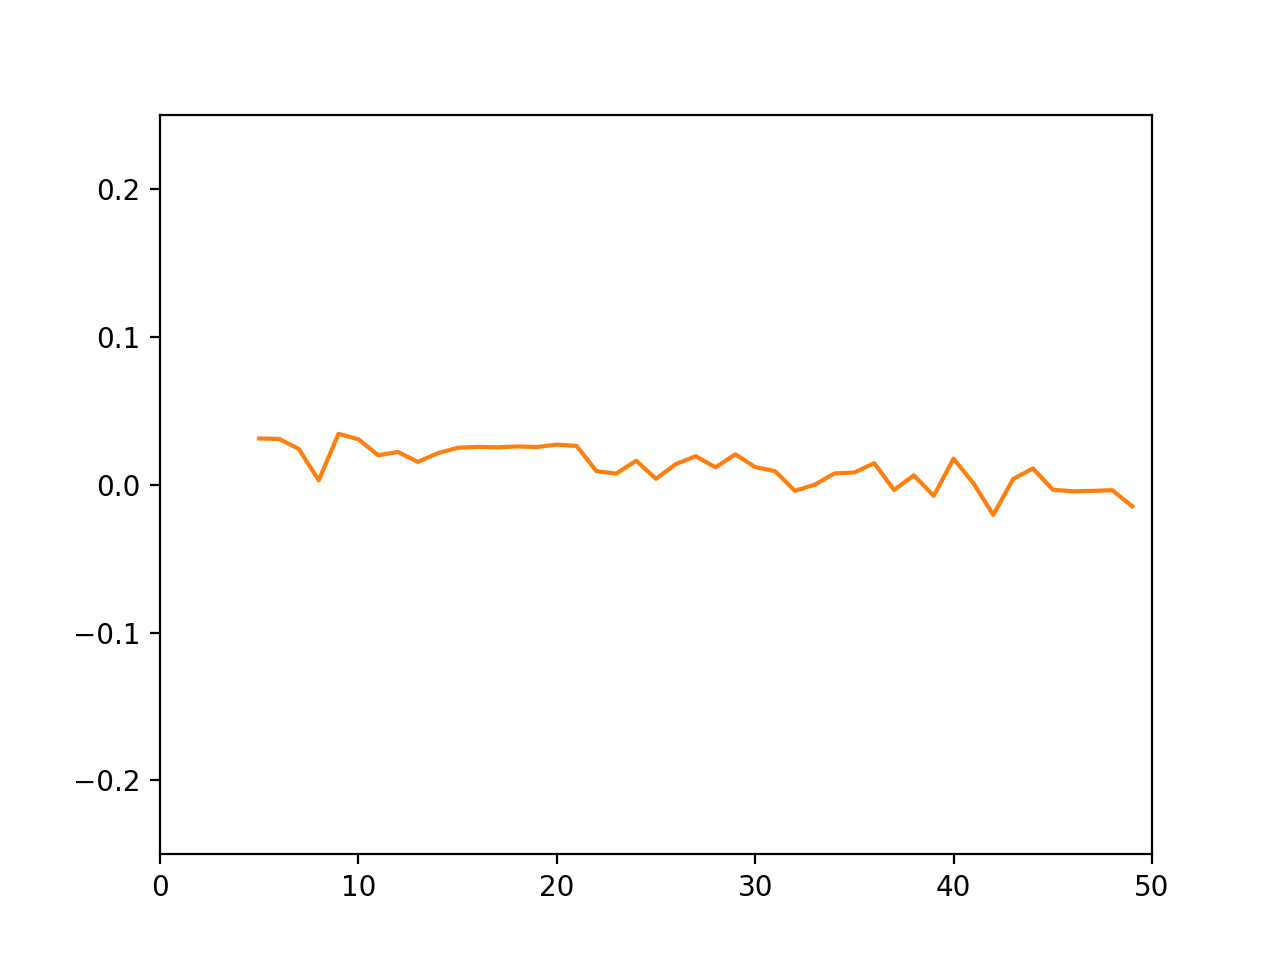

In [21]:
plt.figure()
plt.plot([x for x in range(5,50)], accuracy_rc)
plt.axis([0,50,-0.25,0.25])
plt.show()

In [22]:
# train a k means classifier with K_CLUSTERS_RESTAURANT
from operator import itemgetter
#K_CLUSTERS_RESTAURANT = sorted(accuracy_rc, key=itemgetter(1))[-1][0] # k with best score

km = MiniBatchKMeans(n_clusters=K_CLUSTERS_RESTAURANT, init='k-means++', n_init=5,
                     init_size=100000, batch_size=1000, verbose=True)
km.fit(lsa_X)

Init 1/5 with method: k-means++
Inertia for init 1/5: 335.424896
Init 2/5 with method: k-means++
Inertia for init 2/5: 335.006502
Init 3/5 with method: k-means++
Inertia for init 3/5: 334.301983
Init 4/5 with method: k-means++
Inertia for init 4/5: 337.676153
Init 5/5 with method: k-means++
Inertia for init 5/5: 338.000885
Minibatch iteration 1/100: mean batch inertia: 0.656368, ewa inertia: 0.656368 
Minibatch iteration 2/100: mean batch inertia: 0.630054, ewa inertia: 0.630054 
Minibatch iteration 3/100: mean batch inertia: 0.627079, ewa inertia: 0.627079 
Minibatch iteration 4/100: mean batch inertia: 0.631042, ewa inertia: 0.631042 
Minibatch iteration 5/100: mean batch inertia: 0.621689, ewa inertia: 0.621689 
Minibatch iteration 6/100: mean batch inertia: 0.631067, ewa inertia: 0.631067 
Minibatch iteration 7/100: mean batch inertia: 0.624185, ewa inertia: 0.624185 
Minibatch iteration 8/100: mean batch inertia: 0.619451, ewa inertia: 0.619451 
Minibatch iteration 9/100: mean bat

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=100000, max_iter=100, max_no_improvement=10,
        n_clusters=20, n_init=5, random_state=None,
        reassignment_ratio=0.01, tol=0.0, verbose=True)

In [23]:
# result
print("Top %d terms per cluster:" %TERMS_PER_CLUSTER_RESTAURANT)
original_space_centroids = svd.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(K_CLUSTERS_RESTAURANT):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :TERMS_PER_CLUSTER_RESTAURANT]:
        print(' %s' % terms[ind], end='')
    print()

Top 5 terms per cluster:
Cluster 0: wife fantastic okay value kids
Cluster 1: loud kids fabulous hotel yummy
Cluster 2: ramen japanese korean pho monta
Cluster 3: pho solid korean ayce indian
Cluster 4: husband yummy okay return kids
Cluster 5: daughter kids lol 00 mins
Cluster 6: pho boba ramen korean okay
Cluster 7: yummy lol cute vegan yum
Cluster 8: okay boyfriend boba husband weekday
Cluster 9: challenge 100 kinda boba filipino
Cluster 10: bf okay lol boyfriend yummy
Cluster 11: dont thats absolutely wonderful bucks
Cluster 12: boyfriend lol absolutely bartenders booth
Cluster 13: wife return fantastic okay terrible
Cluster 14: topped creamy ramen okay return
Cluster 15: com select ramen ayce nigiri
Cluster 16: husband fantastic yummy okay absolutely
Cluster 17: boyfriend lol okay yummy alright
Cluster 18: min pm yummy kids alright
Cluster 19: boyfriend haha okay pho cause


In [24]:
from collections import Counter
clusters = km.labels_.tolist()
print(Counter(clusters))

Counter({14: 128, 13: 73, 16: 51, 4: 45, 3: 37, 6: 34, 0: 31, 2: 26, 10: 21, 15: 18, 17: 18, 11: 15, 19: 14, 7: 11, 18: 10, 1: 8, 9: 8, 5: 5, 12: 4, 8: 1})


In [25]:
# add a column 'cluster' to the existing dataframe 
clusters = km.labels_.tolist()
print(len(clusters))
df2.head()

558


,text,user_id,business_id,stars
5,I love love love Patisserie Manon!\n\nI was ex...,-594af_E7Z9VVjQc9pJK3g,A0X1baHPgw9IiBRivu0G9g,5.0
19,I had the pleasure of tasting a couple of thei...,TdYKJgSgY2GF_YJnwsi5yQ,A0X1baHPgw9IiBRivu0G9g,4.0
22,Meep Meep!!\n\nThat was my first thought when ...,y3FcL4bLy0eLlkb0SDPnBQ,A0X1baHPgw9IiBRivu0G9g,5.0
23,I came here on a saturday afternoon and got al...,rHgT6lBbZ2PaHt0UWfTMtw,A0X1baHPgw9IiBRivu0G9g,5.0
28,Love this place. The cakes and pastries are s...,FIk4lQQu1eTe2EpzQ4xhBA,A0X1baHPgw9IiBRivu0G9g,5.0


In [26]:
df2.insert(len(df2.columns),'cluster',0)

In [27]:
df2.head(1000)

,text,user_id,business_id,stars,cluster
5,I love love love Patisserie Manon!\n\nI was ex...,-594af_E7Z9VVjQc9pJK3g,A0X1baHPgw9IiBRivu0G9g,5.0,0
19,I had the pleasure of tasting a couple of thei...,TdYKJgSgY2GF_YJnwsi5yQ,A0X1baHPgw9IiBRivu0G9g,4.0,0
22,Meep Meep!!\n\nThat was my first thought when ...,y3FcL4bLy0eLlkb0SDPnBQ,A0X1baHPgw9IiBRivu0G9g,5.0,0
23,I came here on a saturday afternoon and got al...,rHgT6lBbZ2PaHt0UWfTMtw,A0X1baHPgw9IiBRivu0G9g,5.0,0
28,Love this place. The cakes and pastries are s...,FIk4lQQu1eTe2EpzQ4xhBA,A0X1baHPgw9IiBRivu0G9g,5.0,0
31,I stopped by on their last day before their Su...,k4M43lXJuQMpQW65DTqzIQ,A0X1baHPgw9IiBRivu0G9g,4.0,0
34,I really love their cassoulet and have had it ...,7HOTOydGS7wJYaJqNoDfeg,A0X1baHPgw9IiBRivu0G9g,4.0,0
38,Their macarons are soo unique compared to othe...,5OllWsrKJsYo3XQK6siRKA,A0X1baHPgw9IiBRivu0G9g,5.0,0
42,"I loved this place. I had the turkey, ham and ...",_i3IZYU28R3xgV4hxkmKjw,A0X1baHPgw9IiBRivu0G9g,5.0,0
47,"Cake, macaroons, and more oh my! This place is...",fxrQSMhHlBv6eJVRdchG9Q,A0X1baHPgw9IiBRivu0G9g,5.0,0


In [28]:
for index, row  in df2.iterrows():
    print(index)
    uid = str(row['user_id'])
    ind = -1
    for i in range(0, len(rawdata_user)):
        if(uid == str(rawdata_user[i][0])):
            ind = i
    print(index)
    df2.set_value(index, 'cluster', clusters[ind])


5
5
19
19
22
22
23
23
28
28
31
31
34
34
38
38
42
42
47
47
52
52
57
57
65
65
66
66
68
68
72
72
73
73
77
77
91
91
102
102
103
103
105
105
106
106
109
109
116
116
129
129
131
131
132
132
133
133
134
134
138
138
154
154
158
158
165
165
167
167
171
171
177
177
179
179
188
188
190
190
207
207
209
209
212
212
213
213
216
216
228
228
229
229
237
237
238
238
240
240
249
249
250
250
253
253
255
255
264
264
270
270
271
271
275
275
280
280
282
282
287
287
293
293
304
304
310
310
315
315
317
317
323
323
327
327
332
332
334
334
335
335
344
344
350
350
353
353
354
354
355
355
362
362
366
366
378
378
379
379
385
385
409
409
421
421
423
423
428
428
433
433
435
435
437
437
445
445
446
446
449
449
450
450
451
451
454
454
456
456
465
465
466
466
480
480
484
484
486
486
489
489
492
492
503
503
505
505
506
506
508
508
515
515
517
517
521
521
526
526
532
532
535
535
547
547
549
549
551
551
579
579
618
618
635
635
639
639
676
676
681
681
703
703
843
843
849
849
850
850
923
923
928
928
937
937
958
958
960
960


10665
10665
10675
10675
10687
10687
10691
10691
10717
10717
10718
10718
10719
10719
10728
10728
10732
10732
10817
10817
10846
10846
10878
10878
10911
10911
10914
10914
10964
10964
10965
10965
11075
11075
11076
11076
11080
11080
11091
11091
11097
11097
11133
11133
11143
11143
11154
11154
11178
11178
11179
11179
11183
11183
11193
11193
11196
11196
11197
11197
11199
11199
11269
11269
11347
11347
11349
11349
11350
11350
11389
11389
11439
11439
11455
11455
11466
11466
11468
11468
11469
11469
11470
11470
11481
11481
11488
11488
11502
11502
11504
11504
11520
11520
11534
11534
11565
11565
11610
11610
11613
11613
11619
11619
11639
11639
11664
11664
11700
11700
11719
11719
11724
11724
11738
11738
11747
11747
11764
11764
11768
11768
11789
11789
11806
11806
11817
11817
11834
11834
11873
11873
11885
11885
11904
11904
11942
11942
11951
11951
11959
11959
11990
11990
11995
11995
11998
11998
12001
12001
12010
12010
12024
12024
12048
12048
12068
12068
12082
12082
12092
12092
12095
12095
12102
12102
1216

20854
20859
20859
20860
20860
20864
20864
20865
20865
20869
20869
20875
20875
20880
20880
20882
20882
20884
20884
20895
20895
20904
20904
20909
20909
20916
20916
20919
20919
20931
20931
20954
20954
20980
20980
20990
20990
20998
20998
21000
21000
21006
21006
21007
21007
21014
21014
21018
21018
21021
21021
21031
21031
21036
21036
21043
21043
21056
21056
21062
21062
21063
21063
21067
21067
21071
21071
21072
21072
21087
21087
21089
21089
21106
21106
21111
21111
21112
21112
21138
21138
21143
21143
21149
21149
21153
21153
21160
21160
21165
21165
21181
21181
21185
21185
21187
21187
21188
21188
21195
21195
21201
21201
21208
21208
21229
21229
21230
21230
21241
21241
21259
21259
21265
21265
21279
21279
21293
21293
21308
21308
21353
21353
21375
21375
21390
21390
21400
21400
21407
21407
21433
21433
21459
21459
21467
21467
21515
21515
21533
21533
21539
21539
21554
21554
21559
21559
21573
21573
21575
21575
21584
21584
21589
21589
21590
21590
21591
21591
21597
21597
21598
21598
21603
21603
21620
2162

27735
27736
27736
27750
27750
27765
27765
27781
27781
27798
27798
27799
27799
27803
27803
27864
27864
27880
27880
27883
27883
27899
27899
27907
27907
27911
27911
27917
27917
27930
27930
27938
27938
27965
27965
27968
27968
27978
27978
27996
27996
28008
28008
28031
28031
28055
28055
28064
28064
28078
28078
28093
28093
28114
28114
28117
28117
28142
28142
28152
28152
28159
28159
28161
28161
28164
28164
28166
28166
28171
28171
28213
28213
28216
28216
28219
28219
28236
28236
28256
28256
28259
28259
28278
28278
28279
28279
28287
28287
28300
28300
28308
28308
28313
28313
28314
28314
28315
28315
28316
28316
28344
28344
28353
28353
28360
28360
28367
28367
28376
28376
28390
28390
28411
28411
28418
28418
28430
28430
28443
28443
28451
28451
28456
28456
28473
28473
28484
28484
28488
28488
28502
28502
28518
28518
28523
28523
28532
28532
28542
28542
28545
28545
28553
28553
28572
28572
28592
28592
28610
28610
28625
28625
28626
28626
28634
28634
28650
28650
28666
28666
28725
28725
28747
28747
28761
2876

35845
35847
35847
35850
35850
35853
35853
35854
35854
35862
35862
35863
35863
35866
35866
35867
35867
35868
35868
35871
35871
35877
35877
35880
35880
35896
35896
35911
35911
35914
35914
35920
35920
35921
35921
35923
35923
35932
35932
35999
35999
36006
36006
36017
36017
36020
36020
36029
36029
36032
36032
36039
36039
36064
36064
36069
36069
36073
36073
36083
36083
36091
36091
36106
36106
36116
36116
36117
36117
36121
36121
36142
36142
36155
36155
36171
36171
36174
36174
36175
36175
36176
36176
36178
36178
36206
36206
36210
36210
36211
36211
36213
36213
36216
36216
36223
36223
36229
36229
36237
36237
36242
36242
36243
36243
36253
36253
36269
36269
36279
36279
36285
36285
36293
36293
36302
36302
36310
36310
36312
36312
36323
36323
36328
36328
36336
36336
36345
36345
36355
36355
36362
36362
36380
36380
36381
36381
36387
36387
36398
36398
36403
36403
36404
36404
36405
36405
36408
36408
36411
36411
36424
36424
36426
36426
36429
36429
36439
36439
36449
36449
36456
36456
36470
36470
36478
3647

42470
42470
42471
42471
42488
42488
42503
42503
42507
42507
42515
42515
42520
42520
42522
42522
42525
42525
42530
42530
42535
42535
42543
42543
42552
42552
42554
42554
42568
42568
42574
42574
42589
42589
42606
42606
42637
42637
42651
42651
42652
42652
42653
42653
42668
42668
42673
42673
42676
42676
42692
42692
42696
42696
42712
42712
42721
42721
42724
42724
42734
42734
42746
42746
42755
42755
42792
42792
42799
42799
42800
42800
42806
42806
42807
42807
42811
42811
42815
42815
42832
42832
42837
42837
42840
42840
42850
42850
42852
42852
42855
42855
42858
42858
42867
42867
42868
42868
42869
42869
42875
42875
42879
42879
42884
42884
42885
42885
42909
42909
42927
42927
42929
42929
42936
42936
42940
42940
42957
42957
42959
42959
42971
42971
42981
42981
42984
42984
42995
42995
43003
43003
43022
43022
43037
43037
43043
43043
43047
43047
43048
43048
43051
43051
43053
43053
43062
43062
43065
43065
43086
43086
43092
43092
43096
43096
43102
43102
43107
43107
43110
43110
43114
43114
43135
43135
4318

51640
51640
51660
51660
51663
51663
51667
51667
51696
51696
51706
51706
51711
51711
51715
51715
51745
51745
51747
51747
51750
51750
51759
51759
51771
51771
51799
51799
51825
51825
51860
51860
51874
51874
51880
51880
51884
51884
51897
51897
51905
51905
51916
51916
51928
51928
51944
51944
51947
51947
51949
51949
51958
51958
51960
51960
51963
51963
51982
51982
51985
51985
52008
52008
52015
52015
52016
52016
52038
52038
52051
52051
52205
52205
52357
52357
52411
52411
52443
52443
52462
52462
52463
52463
52468
52468
52482
52482
52493
52493
52510
52510
52511
52511
52537
52537
52559
52559
52563
52563
52564
52564
52591
52591
52600
52600
52608
52608
52614
52614
52629
52629
52630
52630
52632
52632
52661
52661
52674
52674
52679
52679
52683
52683
52706
52706
52728
52728
52790
52790
52795
52795
52803
52803
52822
52822
52824
52824
52845
52845
52856
52856
52882
52882
52888
52888
52901
52901
53003
53003
53008
53008
53022
53022
53023
53023
53025
53025
53026
53026
53027
53027
53029
53029
53031
53031
5303

61034
61059
61059
61063
61063
61111
61111
61149
61149
61152
61152
61169
61169
61170
61170
61175
61175
61177
61177
61187
61187
61189
61189
61201
61201
61220
61220
61225
61225
61226
61226
61228
61228
61241
61241
61244
61244
61256
61256
61262
61262
61296
61296
61510
61510
61512
61512
61514
61514
61518
61518
61538
61538
61539
61539
61547
61547
61549
61549
61554
61554
61558
61558
61572
61572
61577
61577
61578
61578
61627
61627
61647
61647
61659
61659
61663
61663
61668
61668
61681
61681
61685
61685
61697
61697
61698
61698
61748
61748
61749
61749
61750
61750
61753
61753
61802
61802
61852
61852
61882
61882
61903
61903
61909
61909
61927
61927
61940
61940
61948
61948
61956
61956
61957
61957
61959
61959
61962
61962
61965
61965
61972
61972
61994
61994
62009
62009
62015
62015
62016
62016
62022
62022
62024
62024
62035
62035
62051
62051
62069
62069
62083
62083
62092
62092
62093
62093
62111
62111
62138
62138
62165
62165
62171
62171
62175
62175
62190
62190
62194
62194
62198
62198
62206
62206
62218
6221

70655
70660
70660
70676
70676
70681
70681
70682
70682
70683
70683
70688
70688
70693
70693
70696
70696
70699
70699
70706
70706
70710
70710
70721
70721
70746
70746
70747
70747
70759
70759
70760
70760
70761
70761
70762
70762
70773
70773
70788
70788
70798
70798
70803
70803
70810
70810
70816
70816
70840
70840
70842
70842
70843
70843
70859
70859
70872
70872
70920
70920
70925
70925
70934
70934
70940
70940
70942
70942
70953
70953
70956
70956
70960
70960
70970
70970
70979
70979
70986
70986
70994
70994
71032
71032
71034
71034
71040
71040
71042
71042
71043
71043
71127
71127
71132
71132
71138
71138
71164
71164
71165
71165
71180
71180
71249
71249
71258
71258
71289
71289
71303
71303
71311
71311
71315
71315
71332
71332
71338
71338
71340
71340
71347
71347
71361
71361
71365
71365
71371
71371
71385
71385
71413
71413
71418
71418
71427
71427
71436
71436
71456
71456
71513
71513
71684
71684
71689
71689
71698
71698
71703
71703
71742
71742
71747
71747
71788
71788
71815
71815
71859
71859
71882
71882
71891
7189

81704
81715
81715
81727
81727
81728
81728
81729
81729
81730
81730
81734
81734
81740
81740
81753
81753
81756
81756
81757
81757
81762
81762
81764
81764
81771
81771
81776
81776
81777
81777
81779
81779
81793
81793
81816
81816
81820
81820
81833
81833
81842
81842
81854
81854
81861
81861
81873
81873
81874
81874
81888
81888
81893
81893
81902
81902
81914
81914
81918
81918
81929
81929
81951
81951
81960
81960
81991
81991
81998
81998
81999
81999
82020
82020
82024
82024
82047
82047
82103
82103
82136
82136
82143
82143
82193
82193
82218
82218
82251
82251
82282
82282
82283
82283
82290
82290
82300
82300
82310
82310
82311
82311
82339
82339
82341
82341
82344
82344
82353
82353
82357
82357
82361
82361
82362
82362
82371
82371
82373
82373
82377
82377
82390
82390
82401
82401
82407
82407
82435
82435
82438
82438
82537
82537
82621
82621
82629
82629
82634
82634
82640
82640
82645
82645
82654
82654
82656
82656
82664
82664
82668
82668
82671
82671
82682
82682
82683
82683
82704
82704
82706
82706
82710
82710
82714
8271

91177
91195
91195
91199
91199
91275
91275
91276
91276
91282
91282
91321
91321
91356
91356
91368
91368
91383
91383
91394
91394
91401
91401
91408
91408
91432
91432
91443
91443
91581
91581
91594
91594
91595
91595
91603
91603
91616
91616
91638
91638
91649
91649
91660
91660
91692
91692
91696
91696
91738
91738
91746
91746
91750
91750
91772
91772
91775
91775
91841
91841
91850
91850
91871
91871
91872
91872
91889
91889
91891
91891
91899
91899
91901
91901
91902
91902
91919
91919
91933
91933
91934
91934
91937
91937
91955
91955
91956
91956
92009
92009
92047
92047
92058
92058
92059
92059
92063
92063
92071
92071
92072
92072
92075
92075
92087
92087
92094
92094
92095
92095
92097
92097
92102
92102
92109
92109
92111
92111
92114
92114
92131
92131
92140
92140
92141
92141
92184
92184
92196
92196
92209
92209
92228
92228
92233
92233
92236
92236
92304
92304
92314
92314
92371
92371
92374
92374
92496
92496
92499
92499
92503
92503
92509
92509
92518
92518
92531
92531
92537
92537
92549
92549
92575
92575
92598
9259

102507
102507
102511
102511
102525
102525
102560
102560
102623
102623
102635
102635
102654
102654
102679
102679
102693
102693
102695
102695
102785
102785
102812
102812
102841
102841
102904
102904
102912
102912
102925
102925
102945
102945
102975
102975
102983
102983
102989
102989
102999
102999
103017
103017
103026
103026
103064
103064
103070
103070
103107
103107
103120
103120
103123
103123
103133
103133
103142
103142
103164
103164
103178
103178
103195
103195
103199
103199
103210
103210
103227
103227
103231
103231
103245
103245
103248
103248
103250
103250
103251
103251
103255
103255
103258
103258
103259
103259
103262
103262
103276
103276
103277
103277
103278
103278
103280
103280
103288
103288
103292
103292
103299
103299
103301
103301
103303
103303
103315
103315
103408
103408
103437
103437
103439
103439
103445
103445
103461
103461
103475
103475
103490
103490
103549
103549
103586
103586
103589
103589
103593
103593
103596
103596
103598
103598
103600
103600
103603
103603
103612
103612
103620

111496
111496
111511
111511
111622
111622
111624
111624
111631
111631
111634
111634
111643
111643
111650
111650
111659
111659
111673
111673
111680
111680
111692
111692
111699
111699
111706
111706
111711
111711
111730
111730
111744
111744
111762
111762
111780
111780
111784
111784
111785
111785
111793
111793
111794
111794
111811
111811
111817
111817
111827
111827
111853
111853
111880
111880
111969
111969
111979
111979
111980
111980
111981
111981
111983
111983
111991
111991
111992
111992
111996
111996
112010
112010
112016
112016
112021
112021
112024
112024
112025
112025
112039
112039
112045
112045
112049
112049
112050
112050
112067
112067
112083
112083
112084
112084
112086
112086
112088
112088
112099
112099
112106
112106
112120
112120
112124
112124
112156
112156
112169
112169
112186
112186
112189
112189
112200
112200
112201
112201
112224
112224
112232
112232
112251
112251
112314
112314
112342
112342
112347
112347
112370
112370
112375
112375
112379
112379
112380
112380
112406
112406
112407

121579
121579
121591
121591
121596
121596
121619
121619
121620
121620
121747
121747
121758
121758
121776
121776
121787
121787
121816
121816
121817
121817
121821
121821
121840
121840
121849
121849
121856
121856
121858
121858
121861
121861
121872
121872
121894
121894
121952
121952
121954
121954
121964
121964
121988
121988
122014
122014
122015
122015
122016
122016
122019
122019
122023
122023
122028
122028
122046
122046
122047
122047
122048
122048
122049
122049
122060
122060
122065
122065
122067
122067
122083
122083
122089
122089
122094
122094
122096
122096
122103
122103
122112
122112
122114
122114
122121
122121
122124
122124
122126
122126
122133
122133
122137
122137
122182
122182
122202
122202
122217
122217
122227
122227
122236
122236
122244
122244
122246
122246
122248
122248
122253
122253
122262
122262
122270
122270
122281
122281
122285
122285
122288
122288
122292
122292
122306
122306
122308
122308
122360
122360
122373
122373
122408
122408
122430
122430
122446
122446
122456
122456
122458

129278
129302
129302
129314
129314
129336
129336
129367
129367
129384
129384
129447
129447
129468
129468
129479
129479
129522
129522
129530
129530
129532
129532
129533
129533
129547
129547
129553
129553
129558
129558
129570
129570
129571
129571
129584
129584
129591
129591
129592
129592
129593
129593
129594
129594
129634
129634
129649
129649
129656
129656
129665
129665
129687
129687
129720
129720
129723
129723
129737
129737
129752
129752
129779
129779
129805
129805
129818
129818
129820
129820
129821
129821
129833
129833
129839
129839
129842
129842
129845
129845
129852
129852
129856
129856
129858
129858
129863
129863
129891
129891
130006
130006
130025
130025
130026
130026
130045
130045
130073
130073
130076
130076
130087
130087
130110
130110
130115
130115
130122
130122
130134
130134
130171
130171
130172
130172
130180
130180
130195
130195
130197
130197
130200
130200
130207
130207
130213
130213
130214
130214
130216
130216
130219
130219
130221
130221
130228
130228
130237
130237
130238
130238

137957
138047
138047
138053
138053
138075
138075
138102
138102
138132
138132
138139
138139
138140
138140
138166
138166
138170
138170
138180
138180
138192
138192
138197
138197
138203
138203
138205
138205
138212
138212
138224
138224
138234
138234
138242
138242
138243
138243
138255
138255
138257
138257
138260
138260
138270
138270
138284
138284
138298
138298
138299
138299
138313
138313
138327
138327
138355
138355
138364
138364
138374
138374
138397
138397
138403
138403
138433
138433
138442
138442
138447
138447
138455
138455
138487
138487
138511
138511
138538
138538
138551
138551
138604
138604
138654
138654
138684
138684
138723
138723
138737
138737
138749
138749
138770
138770
138778
138778
138800
138800
138804
138804
138812
138812
138919
138919
138939
138939
138940
138940
138942
138942
138974
138974
138986
138986
138998
138998
139021
139021
139023
139023
139054
139054
139081
139081
139102
139102
139105
139105
139114
139114
139131
139131
139145
139145
139147
139147
139155
139155
139162
139162

146435
146455
146455
146460
146460
146484
146484
146488
146488
146492
146492
146497
146497
146503
146503
146516
146516
146517
146517
146528
146528
146541
146541
146551
146551
146561
146561
146575
146575
146603
146603
146608
146608
146620
146620
146633
146633
146660
146660
146723
146723
146727
146727
146730
146730
146761
146761
146766
146766
146771
146771
146774
146774
146787
146787
146793
146793
146810
146810
146814
146814
146818
146818
146820
146820
146838
146838
146847
146847
146861
146861
146899
146899
146906
146906
146941
146941
146949
146949
146952
146952
146953
146953
146967
146967
146972
146972
146986
146986
146987
146987
147000
147000
147009
147009
147010
147010
147026
147026
147039
147039
147050
147050
147063
147063
147068
147068
147072
147072
147093
147093
147097
147097
147104
147104
147111
147111
147119
147119
147122
147122
147125
147125
147127
147127
147144
147144
147149
147149
147155
147155
147162
147162
147191
147191
147206
147206
147212
147212
147213
147213
147231
147231

154273
154273
154274
154274
154277
154277
154280
154280
154287
154287
154301
154301
154303
154303
154310
154310
154313
154313
154314
154314
154315
154315
154325
154325
154336
154336
154337
154337
154353
154353
154377
154377
154406
154406
154407
154407
154417
154417
154429
154429
154435
154435
154460
154460
154471
154471
154475
154475
154480
154480
154482
154482
154493
154493
154494
154494
154531
154531
154538
154538
154541
154541
154545
154545
154554
154554
154564
154564
154574
154574
154578
154578
154579
154579
154580
154580
154596
154596
154597
154597
154599
154599
154608
154608
154612
154612
154617
154617
154633
154633
154637
154637
154642
154642
154659
154659
154670
154670
154671
154671
154731
154731
154758
154758
154767
154767
154770
154770
154771
154771
154774
154774
154775
154775
154786
154786
154790
154790
154797
154797
154798
154798
154804
154804
154813
154813
154814
154814
154821
154821
154822
154822
154833
154833
154837
154837
154843
154843
154847
154847
154854
154854
154904

161428
161430
161430
161432
161432
161433
161433
161435
161435
161445
161445
161446
161446
161447
161447
161449
161449
161450
161450
161454
161454
161460
161460
161463
161463
161466
161466
161480
161480
161483
161483
161487
161487
161496
161496
161508
161508
161509
161509
161525
161525
161529
161529
161534
161534
161538
161538
161540
161540
161544
161544
161554
161554
161570
161570
161596
161596
161602
161602
161607
161607
161609
161609
161614
161614
161622
161622
161627
161627
161628
161628
161629
161629
161632
161632
161633
161633
161637
161637
161638
161638
161648
161648
161649
161649
161657
161657
161666
161666
161671
161671
161685
161685
161700
161700
161720
161720
161747
161747
161748
161748
161778
161778
161800
161800
161827
161827
161829
161829
161869
161869
161890
161890
161896
161896
161901
161901
161924
161924
161930
161930
161935
161935
161937
161937
161940
161940
161946
161946
161947
161947
161961
161961
161970
161970
161988
161988
161991
161991
161995
161995
162014
162014

169919
169921
169921
169932
169932
169937
169937
169951
169951
169999
169999
170026
170026
170027
170027
170028
170028
170030
170030
170103
170103
170112
170112
170113
170113
170129
170129
170155
170155
170169
170169
170195
170195
170214
170214
170216
170216
170231
170231
170235
170235
170261
170261
170269
170269
170295
170295
170298
170298
170300
170300
170304
170304
170307
170307
170411
170411
170420
170420
170424
170424
170426
170426
170433
170433
170436
170436
170441
170441
170445
170445
170469
170469
170471
170471
170473
170473
170511
170511
170512
170512
170513
170513
170518
170518
170524
170524
170539
170539
170557
170557
170561
170561
170566
170566
170571
170571
170572
170572
170573
170573
170574
170574
170583
170583
170595
170595
170615
170615
170622
170622
170634
170634
170635
170635
170642
170642
170651
170651
170652
170652
170661
170661
170671
170671
170686
170686
170689
170689
170744
170744
170784
170784
170795
170795
170808
170808
170814
170814
170817
170817
170826
170826

179709
179823
179823
179836
179836
179954
179954
179963
179963
179998
179998
180008
180008
180062
180062
180085
180085
180097
180097
180106
180106
180107
180107
180117
180117
180134
180134
180137
180137
180154
180154
180155
180155
180172
180172
180232
180232
180258
180258
180455
180455
180503
180503
180556
180556
180570
180570
180582
180582
180600
180600
180602
180602
180606
180606
180614
180614
180615
180615
180629
180629
180646
180646
180655
180655
180659
180659
180679
180679
180743
180743
180747
180747
180751
180751
180763
180763
180775
180775
180788
180788
180793
180793
180798
180798
180803
180803
180813
180813
180814
180814
180828
180828
180832
180832
180836
180836
180843
180843
180845
180845
180851
180851
180858
180858
180864
180864
180866
180866
180888
180888
180899
180899
180900
180900
180918
180918
180922
180922
180926
180926
180962
180962
180963
180963
180965
180965
180969
180969
180986
180986
180990
180990
180991
180991
180992
180992
180993
180993
180999
180999
181008
181008

187679
187686
187686
187687
187687
187704
187704
187706
187706
187728
187728
187743
187743
187748
187748
187750
187750
187762
187762
187766
187766
187777
187777
187779
187779
187781
187781
187783
187783
187784
187784
187787
187787
187789
187789
187791
187791
187793
187793
187796
187796
187803
187803
187811
187811
187816
187816
187825
187825
187838
187838
187861
187861
187863
187863
187865
187865
187866
187866
187874
187874
187875
187875
187885
187885
187900
187900
187921
187921
187942
187942
187946
187946
187961
187961
187980
187980
187995
187995
188005
188005
188018
188018
188033
188033
188035
188035
188043
188043
188052
188052
188070
188070
188098
188098
188101
188101
188109
188109
188128
188128
188133
188133
188134
188134
188180
188180
188192
188192
188215
188215
188241
188241
188250
188250
188252
188252
188282
188282
188301
188301
188314
188314
188321
188321
188324
188324
188340
188340
188370
188370
188376
188376
188378
188378
188380
188380
188388
188388
188391
188391
188420
188420

194991
194991
194993
194993
195019
195019
195021
195021
195032
195032
195038
195038
195040
195040
195048
195048
195051
195051
195068
195068
195070
195070
195079
195079
195125
195125
195129
195129
195130
195130
195138
195138
195139
195139
195141
195141
195143
195143
195150
195150
195156
195156
195160
195160
195172
195172
195174
195174
195197
195197
195198
195198
195206
195206
195211
195211
195231
195231
195258
195258
195280
195280
195294
195294
195314
195314
195337
195337
195348
195348
195354
195354
195378
195378
195392
195392
195403
195403
195407
195407
195429
195429
195447
195447
195457
195457
195461
195461
195471
195471
195473
195473
195480
195480
195483
195483
195494
195494
195509
195509
195516
195516
195518
195518
195532
195532
195534
195534
195536
195536
195545
195545
195550
195550
195553
195553
195568
195568
195590
195590
195607
195607
195615
195615
195616
195616
195665
195665
195666
195666
195669
195669
195680
195680
195689
195689
195728
195728
195792
195792
195795
195795
195822

202165
202166
202166
202175
202175
202182
202182
202184
202184
202192
202192
202195
202195
202200
202200
202202
202202
202206
202206
202212
202212
202213
202213
202224
202224
202225
202225
202240
202240
202245
202245
202250
202250
202253
202253
202255
202255
202256
202256
202267
202267
202291
202291
202309
202309
202315
202315
202347
202347
202355
202355
202364
202364
202373
202373
202375
202375
202381
202381
202393
202393
202500
202500
202513
202513
202523
202523
202524
202524
202536
202536
202548
202548
202557
202557
202558
202558
202563
202563
202572
202572
202573
202573
202576
202576
202580
202580
202604
202604
202607
202607
202610
202610
202614
202614
202620
202620
202623
202623
202630
202630
202633
202633
202638
202638
202640
202640
202641
202641
202643
202643
202653
202653
202658
202658
202660
202660
202666
202666
202678
202678
202682
202682
202685
202685
202689
202689
202694
202694
202695
202695
202709
202709
202717
202717
202718
202718
202720
202720
202721
202721
202730
202730

209430
209505
209505
209521
209521
209528
209528
209569
209569
209700
209700
209705
209705
209728
209728
209744
209744
209765
209765
209768
209768
209780
209780
209787
209787
209799
209799
209801
209801
209836
209836
209848
209848
209881
209881
209882
209882
209900
209900
209906
209906
209908
209908
209916
209916
209917
209917
209924
209924
209937
209937
209938
209938
209943
209943
209959
209959
209960
209960
209969
209969
209978
209978
209984
209984
209987
209987
209990
209990
209998
209998
210010
210010
210018
210018
210020
210020
210022
210022
210039
210039
210049
210049
210059
210059
210060
210060
210078
210078
210097
210097
210120
210120
210122
210122
210155
210155
210159
210159
210162
210162
210230
210230
210245
210245
210280
210280
210286
210286
210373
210373
210400
210400
210442
210442
210444
210444
210449
210449
210454
210454
210455
210455
210458
210458
210467
210467
210475
210475
210495
210495
210505
210505
210508
210508
210520
210520
210526
210526
210538
210538
210547
210547

218040
218040
218044
218044
218045
218045
218081
218081
218084
218084
218088
218088
218096
218096
218115
218115
218122
218122
218131
218131
218132
218132
218140
218140
218149
218149
218158
218158
218160
218160
218164
218164
218167
218167
218168
218168
218169
218169
218175
218175
218180
218180
218197
218197
218204
218204
218208
218208
218210
218210
218211
218211
218212
218212
218216
218216
218223
218223
218233
218233
218248
218248
218254
218254
218256
218256
218283
218283
218292
218292
218302
218302
218318
218318
218322
218322
218338
218338
218344
218344
218349
218349
218350
218350
218352
218352
218353
218353
218371
218371
218382
218382
218387
218387
218391
218391
218393
218393
218398
218398
218404
218404
218411
218411
218448
218448
218456
218456
218458
218458
218468
218468
218478
218478
218495
218495
218502
218502
218525
218525
218533
218533
218535
218535
218547
218547
218552
218552
218572
218572
218574
218574
218605
218605
218607
218607
218608
218608
218628
218628
218739
218739
218750

225200
225200
225210
225210
225257
225257
225262
225262
225265
225265
225285
225285
225312
225312
225330
225330
225331
225331
225360
225360
225362
225362
225363
225363
225369
225369
225372
225372
225374
225374
225381
225381
225394
225394
225407
225407
225411
225411
225424
225424
225426
225426
225427
225427
225437
225437
225438
225438
225474
225474
225475
225475
225478
225478
225499
225499
225507
225507
225514
225514
225537
225537
225545
225545
225549
225549
225557
225557
225562
225562
225594
225594
225595
225595
225607
225607
225638
225638
225672
225672
225675
225675
225690
225690
225691
225691
225695
225695
225723
225723
225727
225727
225743
225743
225754
225754
225758
225758
225763
225763
225766
225766
225770
225770
225779
225779
225782
225782
225784
225784
225785
225785
225789
225789
225793
225793
225802
225802
225805
225805
225814
225814
225830
225830
225833
225833
225846
225846
225852
225852
225853
225853
225858
225858
225869
225869
225872
225872
225874
225874
225876
225876
225877

232593
232593
232596
232596
232598
232598
232600
232600
232656
232656
232715
232715
232721
232721
232731
232731
232745
232745
232746
232746
232748
232748
232776
232776
232795
232795
232808
232808
232811
232811
232816
232816
232820
232820
232822
232822
232825
232825
232834
232834
232838
232838
232840
232840
232844
232844
232852
232852
232856
232856
232859
232859
232862
232862
232865
232865
232866
232866
232873
232873
232884
232884
232887
232887
232896
232896
232900
232900
232901
232901
232906
232906
232919
232919
232920
232920
232929
232929
232930
232930
232931
232931
232933
232933
232934
232934
232942
232942
232952
232952
232963
232963
232971
232971
232999
232999
233004
233004
233020
233020
233025
233025
233039
233039
233065
233065
233067
233067
233079
233079
233082
233082
233086
233086
233089
233089
233147
233147
233151
233151
233161
233161
233170
233170
233196
233196
233199
233199
233205
233205
233206
233206
233208
233208
233215
233215
233224
233224
233226
233226
233241
233241
233245

239278
239285
239285
239302
239302
239311
239311
239312
239312
239318
239318
239328
239328
239347
239347
239355
239355
239358
239358
239368
239368
239372
239372
239382
239382
239387
239387
239414
239414
239436
239436
239470
239470
239475
239475
239483
239483
239508
239508
239537
239537
239546
239546
239553
239553
239564
239564
239566
239566
239573
239573
239618
239618
239621
239621
239625
239625
239649
239649
239652
239652
239674
239674
239676
239676
239680
239680
239685
239685
239693
239693
239709
239709
239710
239710
239717
239717
239719
239719
239730
239730
239742
239742
239745
239745
239747
239747
239748
239748
239753
239753
239758
239758
239761
239761
239764
239764
239772
239772
239775
239775
239781
239781
239782
239782
239786
239786
239797
239797
239800
239800
239801
239801
239806
239806
239810
239810
239818
239818
239819
239819
239823
239823
239830
239830
239832
239832
239836
239836
239837
239837
239838
239838
239860
239860
239861
239861
239867
239867
239871
239871
239873
239873

247190
247205
247205
247260
247260
247265
247265
247286
247286
247297
247297
247312
247312
247324
247324
247407
247407
247436
247436
247451
247451
247475
247475
247480
247480
247485
247485
247504
247504
247511
247511
247512
247512
247516
247516
247517
247517
247539
247539
247546
247546
247564
247564
247622
247622
247633
247633
247702
247702
247714
247714
247721
247721
247724
247724
247739
247739
247745
247745
247752
247752
247755
247755
247779
247779
247783
247783
247785
247785
247787
247787
247868
247868
247875
247875
247910
247910
247922
247922
247932
247932
247957
247957
248002
248002
248011
248011
248057
248057
248088
248088
248090
248090
248110
248110
248118
248118
248125
248125
248156
248156
248165
248165
248169
248169
248188
248188
248189
248189
248193
248193
248208
248208
248218
248218
248220
248220
248225
248225
248236
248236
248246
248246
248251
248251
248287
248287
248312
248312
248322
248322
248330
248330
248336
248336
248337
248337
248338
248338
248347
248347
248352
248352

256565
256586
256586
256589
256589
256625
256625
256727
256727
256729
256729
256735
256735
256750
256750
256756
256756
256795
256795
256805
256805
256833
256833
256843
256843
256846
256846
256849
256849
256857
256857
256866
256866
256880
256880
256895
256895
256900
256900
256904
256904
256956
256956
256992
256992
256999
256999
257064
257064
257075
257075
257081
257081
257101
257101
257124
257124
257128
257128
257162
257162
257164
257164
257168
257168
257171
257171
257200
257200
257265
257265
257273
257273
257281
257281
257285
257285
257286
257286
257290
257290
257295
257295
257300
257300
257308
257308
257309
257309
257311
257311
257312
257312
257314
257314
257320
257320
257326
257326
257330
257330
257344
257344
257345
257345
257347
257347
257349
257349
257354
257354
257367
257367
257381
257381
257383
257383
257389
257389
257401
257401
257414
257414
257415
257415
257417
257417
257418
257418
257422
257422
257442
257442
257449
257449
257453
257453
257462
257462
257475
257475
257508
257508

263893
263893
263923
263923
263926
263926
263938
263938
263944
263944
263947
263947
263952
263952
263954
263954
263958
263958
263964
263964
263978
263978
263989
263989
263990
263990
263991
263991
263997
263997
264000
264000
264012
264012
264035
264035
264036
264036
264062
264062
264080
264080
264081
264081
264092
264092
264100
264100
264105
264105
264120
264120
264129
264129
264135
264135
264181
264181
264187
264187
264225
264225
264265
264265
264268
264268
264270
264270
264275
264275
264282
264282
264285
264285
264286
264286
264288
264288
264308
264308
264312
264312
264314
264314
264336
264336
264340
264340
264341
264341
264342
264342
264348
264348
264359
264359
264367
264367
264381
264381
264382
264382
264385
264385
264386
264386
264391
264391
264410
264410
264470
264470
264478
264478
264487
264487
264493
264493
264499
264499
264502
264502
264521
264521
264525
264525
264529
264529
264554
264554
264563
264563
264584
264584
264588
264588
264603
264603
264632
264632
264634
264634
264646

271820
271820
271825
271825
271828
271828
271846
271846
271861
271861
271868
271868
271872
271872
271876
271876
271884
271884
271888
271888
271891
271891
271896
271896
271899
271899
271908
271908
271915
271915
271925
271925
271937
271937
271945
271945
271968
271968
271975
271975
271976
271976
271990
271990
272001
272001
272016
272016
272031
272031
272036
272036
272042
272042
272056
272056
272065
272065
272066
272066
272078
272078
272130
272130
272133
272133
272159
272159
272181
272181
272204
272204
272205
272205
272213
272213
272214
272214
272228
272228
272242
272242
272244
272244
272246
272246
272261
272261
272275
272275
272279
272279
272291
272291
272292
272292
272296
272296
272299
272299
272306
272306
272311
272311
272322
272322
272329
272329
272348
272348
272369
272369
272377
272377
272378
272378
272419
272419
272550
272550
272604
272604
272662
272662
272690
272690
272802
272802
272895
272895
272901
272901
272907
272907
272914
272914
272925
272925
272936
272936
272940
272940
272942

279221
279221
279231
279231
279290
279290
279303
279303
279307
279307
279324
279324
279336
279336
279347
279347
279348
279348
279352
279352
279379
279379
279405
279405
279441
279441
279507
279507
279510
279510
279557
279557
279569
279569
279579
279579
279582
279582
279619
279619
279628
279628
279630
279630
279639
279639
279642
279642
279647
279647
279648
279648
279652
279652
279656
279656
279658
279658
279663
279663
279669
279669
279673
279673
279689
279689
279690
279690
279711
279711
279713
279713
279715
279715
279718
279718
279720
279720
279722
279722
279734
279734
279742
279742
279743
279743
279747
279747
279761
279761
279767
279767
279771
279771
279772
279772
279779
279779
279782
279782
279786
279786
279788
279788
279793
279793
279794
279794
279795
279795
279799
279799
279801
279801
279806
279806
279810
279810
279816
279816
279827
279827
279828
279828
279829
279829
279830
279830
279831
279831
279837
279837
279859
279859
279862
279862
279863
279863
279873
279873
279878
279878
279887

286338
286338
286341
286341
286348
286348
286362
286362
286365
286365
286381
286381
286399
286399
286402
286402
286413
286413
286424
286424
286433
286433
286436
286436
286496
286496
286521
286521
286536
286536
286604
286604
286614
286614
286630
286630
286633
286633
286681
286681
286697
286697
286700
286700
286723
286723
286745
286745
286756
286756
286780
286780
286795
286795
286816
286816
286822
286822
286830
286830
286880
286880
286910
286910
286947
286947
286948
286948
286967
286967
286972
286972
287121
287121
287268
287268
287289
287289
287333
287333
287437
287437
287499
287499
287505
287505
287599
287599
287657
287657
287667
287667
287747
287747
287895
287895
287899
287899
287901
287901
287950
287950
287973
287973
287984
287984
287999
287999
288023
288023
288028
288028
288032
288032
288059
288059
288182
288182
288222
288222
288225
288225
288241
288241
288267
288267
288359
288359
288373
288373
288424
288424
288425
288425
288475
288475
288495
288495
288502
288502
288639
288639
288984

297226
297227
297227
297235
297235
297238
297238
297248
297248
297257
297257
297267
297267
297281
297281
297282
297282
297284
297284
297287
297287
297291
297291
297307
297307
297312
297312
297317
297317
297329
297329
297332
297332
297345
297345
297361
297361
297363
297363
297366
297366
297367
297367
297377
297377
297396
297396
297399
297399
297401
297401
297402
297402
297403
297403
297429
297429
297440
297440
297448
297448
297449
297449
297489
297489
297510
297510
297532
297532
297538
297538
297547
297547
297550
297550
297557
297557
297562
297562
297602
297602
297617
297617
297624
297624
297637
297637
297643
297643
297652
297652
297655
297655
297662
297662
297674
297674
297699
297699
297717
297717
297724
297724
297737
297737
297797
297797
297833
297833
297843
297843
297883
297883
297893
297893
297905
297905
297913
297913
297914
297914
297929
297929
297972
297972
297977
297977
297980
297980
297985
297985
298003
298003
298007
298007
298013
298013
298022
298022
298026
298026
298033
298033

305448
305448
305450
305450
305454
305454
305459
305459
305463
305463
305475
305475
305497
305497
305508
305508
305510
305510
305517
305517
305524
305524
305525
305525
305528
305528
305530
305530
305533
305533
305542
305542
305553
305553
305556
305556
305569
305569
305575
305575
305604
305604
305605
305605
305611
305611
305612
305612
305613
305613
305619
305619
305623
305623
305629
305629
305630
305630
305640
305640
305643
305643
305646
305646
305648
305648
305662
305662
305674
305674
305695
305695
305702
305702
305706
305706
305711
305711
305713
305713
305732
305732
305737
305737
305742
305742
305768
305768
305777
305777
305779
305779
305781
305781
305788
305788
305790
305790
305804
305804
305810
305810
305813
305813
305814
305814
305831
305831
305838
305838
305843
305843
305852
305852
305853
305853
305856
305856
305862
305862
305872
305872
305887
305887
305889
305889
305897
305897
305905
305905
305907
305907
305908
305908
305911
305911
305917
305917
305923
305923
305934
305934
305952

313046
313053
313053
313057
313057
313066
313066
313076
313076
313089
313089
313091
313091
313117
313117
313118
313118
313119
313119
313143
313143
313180
313180
313192
313192
313204
313204
313213
313213
313222
313222
313242
313242
313243
313243
313256
313256
313301
313301
313318
313318
313376
313376
313398
313398
313406
313406
313429
313429
313470
313470
313473
313473
313474
313474
313478
313478
313481
313481
313491
313491
313501
313501
313505
313505
313508
313508
313509
313509
313527
313527
313540
313540
313541
313541
313543
313543
313545
313545
313554
313554
313561
313561
313562
313562
313570
313570
313583
313583
313587
313587
313592
313592
313593
313593
313597
313597
313602
313602
313603
313603
313623
313623
313625
313625
313633
313633
313650
313650
313658
313658
313667
313667
313679
313679
313682
313682
313686
313686
313692
313692
313709
313709
313710
313710
313711
313711
313713
313713
313730
313730
313740
313740
313742
313742
313747
313747
313749
313749
313752
313752
313755
313755

319467
319467
319489
319489
319495
319495
319517
319517
319541
319541
319552
319552
319566
319566
319579
319579
319588
319588
319630
319630
319643
319643
319655
319655
319678
319678
319699
319699
319705
319705
319722
319722
319744
319744
319747
319747
319759
319759
319763
319763
319830
319830
319848
319848
319954
319954
319960
319960
319964
319964
319969
319969
319973
319973
319987
319987
319989
319989
319990
319990
320012
320012
320025
320025
320040
320040
320043
320043
320056
320056
320064
320064
320068
320068
320069
320069
320070
320070
320075
320075
320076
320076
320088
320088
320092
320092
320093
320093
320096
320096
320097
320097
320098
320098
320101
320101
320102
320102
320112
320112
320113
320113
320116
320116
320119
320119
320130
320130
320132
320132
320135
320135
320136
320136
320141
320141
320147
320147
320149
320149
320151
320151
320164
320164
320169
320169
320177
320177
320179
320179
320180
320180
320192
320192
320196
320196
320202
320202
320225
320225
320231
320231
320241

328857
328870
328870
328882
328882
328901
328901
328906
328906
328907
328907
328908
328908
328909
328909
328910
328910
328911
328911
328924
328924
328927
328927
328928
328928
328932
328932
328933
328933
328943
328943
328944
328944
328947
328947
328965
328965
328967
328967
328972
328972
328974
328974
328977
328977
328980
328980
328988
328988
328997
328997
329000
329000
329028
329028
329029
329029
329034
329034
329041
329041
329042
329042
329049
329049
329051
329051
329060
329060
329061
329061
329063
329063
329071
329071
329073
329073
329091
329091
329106
329106
329116
329116
329122
329122
329133
329133
329139
329139
329148
329148
329151
329151
329160
329160
329162
329162
329164
329164
329168
329168
329175
329175
329178
329178
329186
329186
329188
329188
329209
329209
329213
329213
329227
329227
329232
329232
329239
329239
329248
329248
329253
329253
329258
329258
329274
329274
329288
329288
329293
329293
329296
329296
329300
329300
329318
329318
329322
329322
329325
329325
329332
329332

336264
336268
336268
336287
336287
336293
336293
336303
336303
336314
336314
336331
336331
336335
336335
336344
336344
336347
336347
336362
336362
336363
336363
336366
336366
336377
336377
336378
336378
336380
336380
336406
336406
336437
336437
336438
336438
336442
336442
336467
336467
336477
336477
336492
336492
336494
336494
336506
336506
336520
336520
336540
336540
336545
336545
336553
336553
336554
336554
336560
336560
336581
336581
336585
336585
336587
336587
336588
336588
336591
336591
336604
336604
336609
336609
336610
336610
336654
336654
336657
336657
336658
336658
336684
336684
336691
336691
336698
336698
336705
336705
336725
336725
336755
336755
336767
336767
336771
336771
336780
336780
336783
336783
336785
336785
336788
336788
336798
336798
336816
336816
336827
336827
336828
336828
336855
336855
336857
336857
336870
336870
336871
336871
336874
336874
336878
336878
336888
336888
336904
336904
336907
336907
336914
336914
336918
336918
336933
336933
336944
336944
336957
336957

344819
344819
344907
344907
344908
344908
344909
344909
344918
344918
344940
344940
344941
344941
344942
344942
344944
344944
344972
344972
344991
344991
345009
345009
345010
345010
345054
345054
345056
345056
345079
345079
345140
345140
345183
345183
345187
345187
345193
345193
345297
345297
345340
345340
345390
345390
345433
345433
345465
345465
345474
345474
345496
345496
345504
345504
345561
345561
345580
345580
345646
345646
345653
345653
345661
345661
345684
345684
345692
345692
345724
345724
345735
345735
345757
345757
345774
345774
345796
345796
345806
345806
345886
345886
345888
345888
345956
345956
345961
345961
345983
345983
345985
345985
346021
346021
346039
346039
346046
346046
346063
346063
346067
346067
346080
346080
346110
346110
346117
346117
346125
346125
346128
346128
346147
346147
346180
346180
346182
346182
346187
346187
346209
346209
346216
346216
346268
346268
346273
346273
346280
346280
346295
346295
346296
346296
346300
346300
346311
346311
346312
346312
346318

353333
353333
353387
353387
353388
353388
353396
353396
353413
353413
353419
353419
353430
353430
353439
353439
353442
353442
353444
353444
353450
353450
353457
353457
353461
353461
353464
353464
353468
353468
353471
353471
353481
353481
353488
353488
353489
353489
353493
353493
353495
353495
353496
353496
353504
353504
353509
353509
353513
353513
353519
353519
353522
353522
353532
353532
353540
353540
353562
353562
353564
353564
353565
353565
353575
353575
353610
353610
353626
353626
353627
353627
353639
353639
353650
353650
353651
353651
353654
353654
353657
353657
353660
353660
353664
353664
353672
353672
353676
353676
353677
353677
353679
353679
353700
353700
353775
353775
353827
353827
353881
353881
353922
353922
353923
353923
353940
353940
353941
353941
353960
353960
353961
353961
353992
353992
353993
353993
354039
354039
354043
354043
354057
354057
354067
354067
354079
354079
354080
354080
354086
354086
354106
354106
354125
354125
354133
354133
354148
354148
354152
354152
354228

361205
361205
361223
361223
361251
361251
361268
361268
361285
361285
361342
361342
361344
361344
361397
361397
361427
361427
361518
361518
361534
361534
361539
361539
361559
361559
361570
361570
361600
361600
361615
361615
361704
361704
361735
361735
361736
361736
361744
361744
361924
361924
362004
362004
362024
362024
362037
362037
362056
362056
362071
362071
362085
362085
362138
362138
362170
362170
362176
362176
362194
362194
362219
362219
362226
362226
362232
362232
362233
362233
362251
362251
362256
362256
362276
362276
362307
362307
362312
362312
362327
362327
362336
362336
362346
362346
362347
362347
362348
362348
362401
362401
362415
362415
362417
362417
362426
362426
362433
362433
362435
362435
362436
362436
362437
362437
362438
362438
362448
362448
362449
362449
362460
362460
362479
362479
362484
362484
362493
362493
362510
362510
362512
362512
362589
362589
362590
362590
362592
362592
362615
362615
362617
362617
362623
362623
362627
362627
362637
362637
362656
362656
362672

368900
368918
368918
368958
368958
369019
369019
369042
369042
369048
369048
369071
369071
369077
369077
369087
369087
369104
369104
369120
369120
369151
369151
369154
369154
369162
369162
369171
369171
369237
369237
369241
369241
369245
369245
369263
369263
369297
369297
369299
369299
369300
369300
369323
369323
369325
369325
369335
369335
369346
369346
369347
369347
369351
369351
369354
369354
369367
369367
369373
369373
369388
369388
369390
369390
369412
369412
369425
369425
369426
369426
369430
369430
369435
369435
369478
369478
369509
369509
369523
369523
369558
369558
369568
369568
369629
369629
369656
369656
369681
369681
369696
369696
369736
369736
369771
369771
369797
369797
369805
369805
369807
369807
369822
369822
369831
369831
369839
369839
369840
369840
369846
369846
369857
369857
369859
369859
369861
369861
369867
369867
369869
369869
369870
369870
369873
369873
369878
369878
369879
369879
369885
369885
369886
369886
369891
369891
369892
369892
369896
369896
369907
369907

376005
376013
376013
376064
376064
376088
376088
376157
376157
376164
376164
376194
376194
376201
376201
376210
376210
376242
376242
376255
376255
376258
376258
376265
376265
376277
376277
376282
376282
376284
376284
376285
376285
376287
376287
376288
376288
376291
376291
376296
376296
376299
376299
376318
376318
376361
376361
376366
376366
376367
376367
376373
376373
376383
376383
376390
376390
376394
376394
376396
376396
376397
376397
376399
376399
376404
376404
376413
376413
376427
376427
376428
376428
376435
376435
376438
376438
376442
376442
376445
376445
376460
376460
376461
376461
376462
376462
376465
376465
376469
376469
376475
376475
376552
376552
376559
376559
376566
376566
376588
376588
376597
376597
376598
376598
376603
376603
376608
376608
376623
376623
376662
376662
376693
376693
376706
376706
376865
376865
376928
376928
376943
376943
376944
376944
376945
376945
376947
376947
376952
376952
376964
376964
376980
376980
376999
376999
377009
377009
377015
377015
377023
377023

382424
382440
382440
382469
382469
382475
382475
382483
382483
382500
382500
382502
382502
382507
382507
382513
382513
382530
382530
382537
382537
382538
382538
382544
382544
382552
382552
382555
382555
382556
382556
382595
382595
382596
382596
382603
382603
382618
382618
382624
382624
382627
382627
382631
382631
382632
382632
382634
382634
382637
382637
382651
382651
382653
382653
382655
382655
382663
382663
382679
382679
382683
382683
382692
382692
382695
382695
382702
382702
382710
382710
382725
382725
382750
382750
382770
382770
382784
382784
382785
382785
382800
382800
382805
382805
382807
382807
382824
382824
382826
382826
382829
382829
382831
382831
382840
382840
382848
382848
382850
382850
382859
382859
382862
382862
382863
382863
382864
382864
382873
382873
382882
382882
382883
382883
382884
382884
382885
382885
382894
382894
382899
382899
382921
382921
382960
382960
382964
382964
382968
382968
382986
382986
383003
383003
383026
383026
383052
383052
383064
383064
383071
383071

392703
392721
392721
392723
392723
392735
392735
392744
392744
392745
392745
392750
392750
392755
392755
392758
392758
392762
392762
392763
392763
392777
392777
392779
392779
392809
392809
392824
392824
392839
392839
392854
392854
392861
392861
392862
392862
392873
392873
392876
392876
392880
392880
392893
392893
392896
392896
392898
392898
392909
392909
392910
392910
392953
392953
392987
392987
393006
393006
393014
393014
393018
393018
393025
393025
393027
393027
393028
393028
393029
393029
393064
393064
393070
393070
393080
393080
393122
393122
393149
393149
393151
393151
393162
393162
393166
393166
393167
393167
393173
393173
393174
393174
393177
393177
393183
393183
393202
393202
393210
393210
393236
393236
393254
393254
393282
393282
393288
393288
393312
393312
393319
393319
393323
393323
393330
393330
393362
393362
393409
393409
393417
393417
393421
393421
393430
393430
393444
393444
393449
393449
393451
393451
393458
393458
393471
393471
393474
393474
393484
393484
393496
393496

399513
399513
399514
399514
399521
399521
399524
399524
399532
399532
399551
399551
399564
399564
399571
399571
399575
399575
399579
399579
399585
399585
399586
399586
399595
399595
399596
399596
399601
399601
399608
399608
399609
399609
399616
399616
399620
399620
399624
399624
399630
399630
399633
399633
399639
399639
399641
399641
399643
399643
399651
399651
399656
399656
399661
399661
399684
399684
399756
399756
399806
399806
399818
399818
399826
399826
399870
399870
399880
399880
399927
399927
399972
399972
399982
399982
400014
400014
400031
400031
400049
400049
400112
400112
400127
400127
400131
400131
400201
400201
400228
400228
400297
400297
400318
400318
400319
400319
400322
400322
400333
400333
400346
400346
400379
400379
400405
400405
400420
400420
400436
400436
400445
400445
400468
400468
400480
400480
400485
400485
400490
400490
400500
400500
400501
400501
400521
400521
400526
400526
400531
400531
400548
400548
400569
400569
400575
400575
400590
400590
400591
400591
400602

409516
409516
409517
409517
409521
409521
409541
409541
409544
409544
409549
409549
409552
409552
409557
409557
409559
409559
409563
409563
409574
409574
409595
409595
409600
409600
409610
409610
409623
409623
409656
409656
409665
409665
409673
409673
409682
409682
409690
409690
409692
409692
409699
409699
409700
409700
409702
409702
409745
409745
409750
409750
409761
409761
409773
409773
409812
409812
409844
409844
409870
409870
409871
409871
409909
409909
409910
409910
409921
409921
409931
409931
409934
409934
409935
409935
409937
409937
409939
409939
409987
409987
410004
410004
410008
410008
410010
410010
410011
410011
410017
410017
410019
410019
410027
410027
410029
410029
410031
410031
410042
410042
410047
410047
410059
410059
410061
410061
410069
410069
410073
410073
410081
410081
410087
410087
410098
410098
410104
410104
410108
410108
410131
410131
410134
410134
410145
410145
410164
410164
410166
410166
410174
410174
410185
410185
410195
410195
410203
410203
410212
410212
410220

417238
417238
417264
417264
417283
417283
417307
417307
417323
417323
417402
417402
417405
417405
417424
417424
417470
417470
417514
417514
417526
417526
417579
417579
417620
417620
417732
417732
417799
417799
417892
417892
417912
417912
417941
417941
417962
417962
418017
418017
418027
418027
418087
418087
418285
418285
418326
418326
418420
418420
418437
418437
418438
418438
418474
418474
418501
418501
418512
418512
418557
418557
418600
418600
418618
418618
418636
418636
418660
418660
418666
418666
418673
418673
418683
418683
418750
418750
418831
418831
418856
418856
418902
418902
418929
418929
419026
419026
419031
419031
419049
419049
419065
419065
419172
419172
419278
419278
419282
419282
419301
419301
419320
419320
419356
419356
419453
419453
419466
419466
419479
419479
419641
419641
419676
419676
419688
419688
419699
419699
419727
419727
419731
419731
419756
419756
419941
419941
419948
419948
419959
419959
419984
419984
420050
420050
420082
420082
420083
420083
420096
420096
420100

428177
428177
428190
428190
428192
428192
428194
428194
428199
428199
428207
428207
428212
428212
428213
428213
428215
428215
428218
428218
428229
428229
428230
428230
428233
428233
428243
428243
428247
428247
428269
428269
428272
428272
428276
428276
428288
428288
428298
428298
428302
428302
428306
428306
428310
428310
428317
428317
428322
428322
428328
428328
428345
428345
428354
428354
428359
428359
428374
428374
428400
428400
428418
428418
428435
428435
428440
428440
428443
428443
428455
428455
428459
428459
428460
428460
428485
428485
428488
428488
428496
428496
428499
428499
428507
428507
428523
428523
428525
428525
428536
428536
428559
428559
428563
428563
428568
428568
428570
428570
428572
428572
428580
428580
428581
428581
428582
428582
428583
428583
428586
428586
428587
428587
428600
428600
428606
428606
428615
428615
428617
428617
428620
428620
428633
428633
428639
428639
428640
428640
428649
428649
428658
428658
428666
428666
428668
428668
428672
428672
428684
428684
428692

439472
439490
439490
439496
439496
439499
439499
439500
439500
439510
439510
439514
439514
439522
439522
439528
439528
439529
439529
439532
439532
439538
439538
439545
439545
439549
439549
439555
439555
439560
439560
439561
439561
439570
439570
439580
439580
439581
439581
439583
439583
439586
439586
439590
439590
439600
439600
439606
439606
439617
439617
439629
439629
439641
439641
439642
439642
439655
439655
439660
439660
439670
439670
439673
439673
439687
439687
439692
439692
439696
439696
439729
439729
439734
439734
439745
439745
439790
439790
439866
439866
439925
439925
439995
439995
440019
440019
440042
440042
440043
440043
440055
440055
440063
440063
440129
440129
440151
440151
440157
440157
440158
440158
440188
440188
440216
440216
440225
440225
440233
440233
440240
440240
440242
440242
440243
440243
440249
440249
440293
440293
440298
440298
440304
440304
440305
440305
440307
440307
440320
440320
440334
440334
440335
440335
440343
440343
440366
440366
440394
440394
440396
440396

447650
447652
447652
447668
447668
447684
447684
447716
447716
447733
447733
447749
447749
447774
447774
447797
447797
447805
447805
447867
447867
447889
447889
447939
447939
447940
447940
447962
447962
448048
448048
448051
448051
448083
448083
448120
448120
448131
448131
448137
448137
448140
448140
448164
448164
448166
448166
448171
448171
448180
448180
448202
448202
448211
448211
448224
448224
448225
448225
448226
448226
448228
448228
448229
448229
448240
448240
448249
448249
448258
448258
448288
448288
448298
448298
448303
448303
448316
448316
448322
448322
448353
448353
448407
448407
448414
448414
448415
448415
448450
448450
448451
448451
448454
448454
448460
448460
448476
448476
448478
448478
448479
448479
448494
448494
448499
448499
448506
448506
448507
448507
448509
448509
448544
448544
448560
448560
448575
448575
448576
448576
448589
448589
448601
448601
448627
448627
448645
448645
448649
448649
448692
448692
448693
448693
448700
448700
448714
448714
448720
448720
448737
448737

454004
454017
454017
454018
454018
454020
454020
454028
454028
454029
454029
454033
454033
454052
454052
454054
454054
454056
454056
454059
454059
454060
454060
454062
454062
454085
454085
454086
454086
454106
454106
454109
454109
454114
454114
454116
454116
454117
454117
454122
454122
454127
454127
454128
454128
454131
454131
454136
454136
454139
454139
454144
454144
454167
454167
454171
454171
454173
454173
454174
454174
454182
454182
454217
454217
454219
454219
454221
454221
454226
454226
454228
454228
454244
454244
454254
454254
454270
454270
454285
454285
454293
454293
454311
454311
454317
454317
454320
454320
454325
454325
454326
454326
454349
454349
454370
454370
454373
454373
454374
454374
454391
454391
454400
454400
454414
454414
454418
454418
454421
454421
454423
454423
454428
454428
454430
454430
454432
454432
454442
454442
454443
454443
454444
454444
454449
454449
454451
454451
454452
454452
454455
454455
454456
454456
454467
454467
454472
454472
454490
454490
454499
454499

460369
460398
460398
460403
460403
460446
460446
460466
460466
460500
460500
460503
460503
460513
460513
460517
460517
460523
460523
460555
460555
460587
460587
460589
460589
460591
460591
460603
460603
460610
460610
460618
460618
460629
460629
460631
460631
460645
460645
460646
460646
460647
460647
460660
460660
460682
460682
460683
460683
460704
460704
460712
460712
460727
460727
460730
460730
460736
460736
460757
460757
460765
460765
460770
460770
460771
460771
460819
460819
460822
460822
460871
460871
460935
460935
460942
460942
460948
460948
460950
460950
460953
460953
460969
460969
460977
460977
460979
460979
460981
460981
460983
460983
460987
460987
460988
460988
460994
460994
461000
461000
461006
461006
461007
461007
461013
461013
461018
461018
461046
461046
461055
461055
461065
461065
461086
461086
461093
461093
461098
461098
461100
461100
461103
461103
461110
461110
461112
461112
461117
461117
461121
461121
461123
461123
461168
461168
461182
461182
461189
461189
461193
461193

471639
471639
471640
471640
471666
471666
471669
471669
471674
471674
471677
471677
471701
471701
471707
471707
471716
471716
471732
471732
471734
471734
471782
471782
471783
471783
471784
471784
471787
471787
471812
471812
471820
471820
471828
471828
471858
471858
471903
471903
471937
471937
471938
471938
471957
471957
471970
471970
471973
471973
471992
471992
471994
471994
472015
472015
472018
472018
472028
472028
472031
472031
472059
472059
472091
472091
472119
472119
472123
472123
472140
472140
472145
472145
472148
472148
472153
472153
472159
472159
472160
472160
472165
472165
472169
472169
472186
472186
472187
472187
472197
472197
472205
472205
472206
472206
472207
472207
472213
472213
472218
472218
472226
472226
472227
472227
472235
472235
472241
472241
472246
472246
472247
472247
472256
472256
472260
472260
472275
472275
472280
472280
472284
472284
472311
472311
472312
472312
472314
472314
472320
472320
472340
472340
472341
472341
472364
472364
472407
472407
472414
472414
472424

480467
480467
480486
480486
480495
480495
480500
480500
480505
480505
480508
480508
480513
480513
480524
480524
480531
480531
480544
480544
480558
480558
480565
480565
480569
480569
480578
480578
480592
480592
480597
480597
480598
480598
480599
480599
480601
480601
480606
480606
480623
480623
480625
480625
480631
480631
480645
480645
480650
480650
480662
480662
480666
480666
480668
480668
480673
480673
480688
480688
480689
480689
480694
480694
480713
480713
480716
480716
480719
480719
480733
480733
480734
480734
480749
480749
480758
480758
480766
480766
480786
480786
480799
480799
480811
480811
480821
480821
480829
480829
480833
480833
480839
480839
480853
480853
480870
480870
480879
480879
480900
480900
480919
480919
480937
480937
480956
480956
480961
480961
480986
480986
480989
480989
480999
480999
481011
481011
481021
481021
481023
481023
481039
481039
481049
481049
481064
481064
481074
481074
481086
481086
481101
481101
481107
481107
481111
481111
481115
481115
481122
481122
481126

486803
486803
486813
486813
486815
486815
486830
486830
486831
486831
486839
486839
486841
486841
486913
486913
486922
486922
486928
486928
486954
486954
486955
486955
486965
486965
486968
486968
486990
486990
487006
487006
487051
487051
487067
487067
487070
487070
487125
487125
487130
487130
487148
487148
487166
487166
487173
487173
487178
487178
487180
487180
487182
487182
487193
487193
487201
487201
487214
487214
487223
487223
487243
487243
487265
487265
487273
487273
487293
487293
487303
487303
487305
487305
487324
487324
487350
487350
487359
487359
487371
487371
487434
487434
487444
487444
487475
487475
487497
487497
487511
487511
487621
487621
487626
487626
487638
487638
487642
487642
487650
487650
487652
487652
487655
487655
487656
487656
487663
487663
487672
487672
487674
487674
487676
487676
487681
487681
487696
487696
487703
487703
487704
487704
487705
487705
487707
487707
487709
487709
487711
487711
487713
487713
487716
487716
487723
487723
487734
487734
487739
487739
487762

495312
495312
495313
495313
495316
495316
495343
495343
495346
495346
495355
495355
495357
495357
495362
495362
495374
495374
495376
495376
495388
495388
495395
495395
495402
495402
495404
495404
495406
495406
495416
495416
495422
495422
495423
495423
495425
495425
495431
495431
495438
495438
495440
495440
495452
495452
495455
495455
495464
495464
495492
495492
495493
495493
495503
495503
495515
495515
495517
495517
495521
495521
495524
495524
495538
495538
495554
495554
495556
495556
495579
495579
495598
495598
495599
495599
495611
495611
495617
495617
495619
495619
495622
495622
495638
495638
495640
495640
495641
495641
495649
495649
495653
495653
495703
495703
495704
495704
495711
495711
495740
495740
495749
495749
495762
495762
495773
495773
495778
495778
495779
495779
495783
495783
495797
495797
495799
495799
495815
495815
495818
495818
495819
495819
495825
495825
495827
495827
495828
495828
495830
495830
495840
495840
495853
495853
495860
495860
495863
495863
495865
495865
495878

505073
505098
505098
505115
505115
505122
505122
505125
505125
505128
505128
505141
505141
505146
505146
505151
505151
505189
505189
505199
505199
505319
505319
505322
505322
505325
505325
505329
505329
505335
505335
505337
505337
505358
505358
505361
505361
505365
505365
505370
505370
505371
505371
505381
505381
505395
505395
505412
505412
505430
505430
505437
505437
505460
505460
505470
505470
505496
505496
505499
505499
505526
505526
505536
505536
505538
505538
505542
505542
505581
505581
505594
505594
505635
505635
505642
505642
505650
505650
505666
505666
505686
505686
505708
505708
505724
505724
505747
505747
505765
505765
505768
505768
505781
505781
505786
505786
505789
505789
505790
505790
505828
505828
505829
505829
505830
505830
505833
505833
505842
505842
505888
505888
505905
505905
505911
505911
505916
505916
505918
505918
505974
505974
505978
505978
505995
505995
506024
506024
506026
506026
506030
506030
506033
506033
506037
506037
506087
506087
506093
506093
506097
506097

515447
515536
515536
515545
515545
515575
515575
515667
515667
515841
515841
515887
515887
515901
515901
515905
515905
515977
515977
516004
516004
516005
516005
516068
516068
516166
516166
516210
516210
516231
516231
516236
516236
516239
516239
516310
516310
516312
516312
516339
516339
516371
516371
516402
516402
516478
516478
516480
516480
516566
516566
516580
516580
516645
516645
516671
516671
516715
516715
516813
516813
516827
516827
516914
516914
516925
516925
516938
516938
516944
516944
516945
516945
516949
516949
516964
516964
516971
516971
516986
516986
516988
516988
517004
517004
517005
517005
517018
517018
517033
517033
517036
517036
517042
517042
517051
517051
517081
517081
517092
517092
517109
517109
517111
517111
517114
517114
517138
517138
517139
517139
517151
517151
517152
517152
517171
517171
517176
517176
517185
517185
517192
517192
517211
517211
517212
517212
517224
517224
517255
517255
517256
517256
517325
517325
517358
517358
517371
517371
517394
517394
517481
517481

527957
527957
527968
527968
527972
527972
527982
527982
527989
527989
528004
528004
528040
528040
528058
528058
528067
528067
528073
528073
528077
528077
528083
528083
528084
528084
528107
528107
528142
528142
528205
528205
528206
528206
528207
528207
528242
528242
528300
528300
528319
528319
528323
528323
528341
528341
528342
528342
528445
528445
528461
528461
528495
528495
528502
528502
528527
528527
528538
528538
528543
528543
528560
528560
528572
528572
528627
528627
528644
528644
528651
528651
528655
528655
528671
528671
528679
528679
528691
528691
528705
528705
528712
528712
528718
528718
528719
528719
528729
528729
528742
528742
528744
528744
528809
528809
528811
528811
528861
528861
528907
528907
528924
528924
528929
528929
528936
528936
528989
528989
529016
529016
529123
529123
529159
529159
529174
529174
529177
529177
529214
529214
529217
529217
529230
529230
529234
529234
529241
529241
529286
529286
529299
529299
529302
529302
529305
529305
529311
529311
529315
529315
529327

535649
535650
535650
535660
535660
535662
535662
535663
535663
535675
535675
535688
535688
535689
535689
535698
535698
535703
535703
535708
535708
535712
535712
535724
535724
535725
535725
535726
535726
535728
535728
535730
535730
535750
535750
535755
535755
535758
535758
535761
535761
535762
535762
535767
535767
535776
535776
535777
535777
535786
535786
535796
535796
535800
535800
535833
535833
535889
535889
535895
535895
535962
535962
536006
536006
536020
536020
536039
536039
536044
536044
536048
536048
536051
536051
536054
536054
536076
536076
536112
536112
536183
536183
536185
536185
536186
536186
536193
536193
536206
536206
536207
536207
536229
536229
536250
536250
536279
536279
536283
536283
536291
536291
536293
536293
536297
536297
536298
536298
536311
536311
536322
536322
536336
536336
536337
536337
536338
536338
536347
536347
536355
536355
536356
536356
536369
536369
536372
536372
536376
536376
536380
536380
536389
536389
536396
536396
536404
536404
536407
536407
536411
536411

542959
542959
542979
542979
542997
542997
543002
543002
543031
543031
543059
543059
543067
543067
543190
543190
543237
543237
543283
543283
543310
543310
543336
543336
543347
543347
543350
543350
543451
543451
543489
543489
543574
543574
543581
543581
543584
543584
543642
543642
543653
543653
543658
543658
543677
543677
543711
543711
543725
543725
543737
543737
543798
543798
543891
543891
543912
543912
543988
543988
544010
544010
544042
544042
544052
544052
544068
544068
544081
544081
544084
544084
544092
544092
544111
544111
544116
544116
544144
544144
544149
544149
544151
544151
544155
544155
544157
544157
544162
544162
544167
544167
544169
544169
544172
544172
544182
544182
544191
544191
544196
544196
544200
544200
544202
544202
544211
544211
544219
544219
544226
544226
544227
544227
544228
544228
544252
544252
544266
544266
544272
544272
544277
544277
544279
544279
544290
544290
544300
544300
544308
544308
544319
544319
544326
544326
544345
544345
544352
544352
544401
544401
544411

551485
551485
551488
551488
551498
551498
551505
551505
551508
551508
551511
551511
551522
551522
551526
551526
551529
551529
551532
551532
551540
551540
551543
551543
551551
551551
551568
551568
551593
551593
551612
551612
551620
551620
551626
551626
551629
551629
551630
551630
551641
551641
551643
551643
551646
551646
551649
551649
551655
551655
551658
551658
551667
551667
551668
551668
551672
551672
551679
551679
551680
551680
551687
551687
551697
551697
551699
551699
551751
551751
551758
551758
551760
551760
551776
551776
551781
551781
551793
551793
551797
551797
551805
551805
551812
551812
551845
551845
551851
551851
551865
551865
551873
551873
551874
551874
551881
551881
551882
551882
551886
551886
551892
551892
551906
551906
551910
551910
551929
551929
551950
551950
551951
551951
551965
551965
551967
551967
551986
551986
551987
551987
551989
551989
551991
551991
552000
552000
552015
552015
552022
552022
552023
552023
552029
552029
552037
552037
552051
552051
552058
552058
552062

556831
556831
556837
556837
556841
556841
556847
556847
556868
556868
556872
556872
556884
556884
556886
556886
556893
556893
556903
556903
556919
556919
556933
556933
556937
556937
556943
556943
556952
556952
556953
556953
556960
556960
556962
556962
556968
556968
556974
556974
556975
556975
556988
556988
557028
557028
557032
557032
557052
557052
557053
557053
557055
557055
557059
557059
557061
557061
557082
557082
557099
557099
557120
557120
557131
557131
557140
557140
557151
557151
557172
557172
557184
557184
557193
557193
557198
557198
557263
557263
557267
557267
557283
557283
557284
557284
557291
557291
557292
557292
557304
557304
557319
557319
557320
557320
557326
557326
557338
557338
557362
557362
557369
557369
557390
557390
557399
557399
557404
557404
557425
557425
557427
557427
557428
557428
557459
557459
557483
557483
557509
557509
557529
557529
557553
557553
557560
557560
557573
557573
557589
557589
557591
557591
557683
557683
557689
557689
557811
557811
557889
557889
557918

564328
564330
564330
564334
564334
564336
564336
564340
564340
564347
564347
564372
564372
564376
564376
564382
564382
564383
564383
564384
564384
564402
564402
564412
564412
564413
564413
564422
564422
564432
564432
564446
564446
564454
564454
564455
564455
564471
564471
564484
564484
564496
564496
564501
564501
564511
564511
564520
564520
564522
564522
564537
564537
564544
564544
564554
564554
564556
564556
564568
564568
564572
564572
564584
564584
564597
564597
564599
564599
564604
564604
564614
564614
564620
564620
564666
564666
564667
564667
564696
564696
564705
564705
564720
564720
564731
564731
564736
564736
564772
564772
564778
564778
564788
564788
564818
564818
564830
564830
564833
564833
564862
564862
564863
564863
564871
564871
564872
564872
564885
564885
564891
564891
564897
564897
564898
564898
564912
564912
564922
564922
564926
564926
564929
564929
564942
564942
564952
564952
565000
565000
565007
565007
565011
565011
565029
565029
565058
565058
565062
565062
565068
565068

572891
572891
572902
572902
572909
572909
572910
572910
573069
573069
573137
573137
573143
573143
573147
573147
573154
573154
573160
573160
573172
573172
573181
573181
573185
573185
573191
573191
573203
573203
573205
573205
573210
573210
573215
573215
573220
573220
573221
573221
573236
573236
573242
573242
573253
573253
573263
573263
573287
573287
573289
573289
573290
573290
573295
573295
573321
573321
573336
573336
573402
573402
573407
573407
573415
573415
573417
573417
573425
573425
573432
573432
573452
573452
573456
573456
573464
573464
573493
573493
573501
573501
573539
573539
573555
573555
573592
573592
573616
573616
573619
573619
573625
573625
573638
573638
573639
573639
573643
573643
573692
573692
573746
573746
573805
573805
573840
573840
573904
573904
573908
573908
573926
573926
574082
574082
574085
574085
574123
574123
574124
574124
574163
574163
574204
574204
574214
574214
574215
574215
574223
574223
574225
574225
574235
574235
574237
574237
574246
574246
574252
574252
574284

580103
580115
580115
580150
580150
580202
580202
580206
580206
580212
580212
580216
580216
580219
580219
580227
580227
580232
580232
580265
580265
580281
580281
580290
580290
580307
580307
580322
580322
580363
580363
580364
580364
580366
580366
580377
580377
580423
580423
580439
580439
580446
580446
580450
580450
580457
580457
580459
580459
580461
580461
580467
580467
580475
580475
580478
580478
580505
580505
580510
580510
580512
580512
580551
580551
580573
580573
580612
580612
580619
580619
580620
580620
580622
580622
580625
580625
580663
580663
580670
580670
580681
580681
580693
580693
580698
580698
580701
580701
580718
580718
580731
580731
580739
580739
580745
580745
580759
580759
580790
580790
580802
580802
580828
580828
580830
580830
580848
580848
580852
580852
580904
580904
580916
580916
580926
580926
580940
580940
580963
580963
581014
581014
581035
581035
581062
581062
581092
581092
581101
581101
581113
581113
581154
581154
581158
581158
581184
581184
581204
581204
581210
581210

587078
587084
587084
587087
587087
587093
587093
587102
587102
587109
587109
587113
587113
587114
587114
587138
587138
587161
587161
587168
587168
587178
587178
587262
587262
587277
587277
587286
587286
587343
587343
587371
587371
587374
587374
587378
587378
587380
587380
587390
587390
587400
587400
587411
587411
587451
587451
587464
587464
587492
587492
587501
587501
587556
587556
587577
587577
587579
587579
587581
587581
587591
587591
587597
587597
587603
587603
587607
587607
587614
587614
587623
587623
587648
587648
587678
587678
587679
587679
587681
587681
587690
587690
587694
587694
587718
587718
587720
587720
587721
587721
587737
587737
587740
587740
587751
587751
587756
587756
587764
587764
587769
587769
587805
587805
587807
587807
587815
587815
587825
587825
587834
587834
587863
587863
587871
587871
587872
587872
587875
587875
587877
587877
587890
587890
587893
587893
587898
587898
587899
587899
587920
587920
587928
587928
587929
587929
587936
587936
587960
587960
587983
587983

596755
596755
596760
596760
596790
596790
596797
596797
596808
596808
596810
596810
596813
596813
596819
596819
596825
596825
596827
596827
596868
596868
596873
596873
596876
596876
596878
596878
596896
596896
596902
596902
596910
596910
596925
596925
596941
596941
596957
596957
596967
596967
596980
596980
596984
596984
596987
596987
596995
596995
597005
597005
597007
597007
597012
597012
597017
597017
597021
597021
597027
597027
597039
597039
597042
597042
597043
597043
597048
597048
597052
597052
597053
597053
597067
597067
597072
597072
597081
597081
597082
597082
597083
597083
597090
597090
597102
597102
597107
597107
597117
597117
597121
597121
597124
597124
597126
597126
597127
597127
597135
597135
597140
597140
597143
597143
597144
597144
597167
597167
597173
597173
597206
597206
597212
597212
597217
597217
597221
597221
597244
597244
597245
597245
597248
597248
597253
597253
597274
597274
597280
597280
597286
597286
597287
597287
597295
597295
597297
597297
597303
597303
597307

604016
604016
604021
604021
604022
604022
604023
604023
604067
604067
604077
604077
604109
604109
604115
604115
604116
604116
604136
604136
604192
604192
604194
604194
604195
604195
604197
604197
604202
604202
604203
604203
604204
604204
604221
604221
604241
604241
604247
604247
604252
604252
604298
604298
604300
604300
604305
604305
604308
604308
604321
604321
604325
604325
604326
604326
604332
604332
604357
604357
604361
604361
604380
604380
604381
604381
604383
604383
604392
604392
604406
604406
604412
604412
604413
604413
604432
604432
604434
604434
604454
604454
604470
604470
604556
604556
604577
604577
604586
604586
604604
604604
604621
604621
604648
604648
604674
604674
604678
604678
604688
604688
604691
604691
604698
604698
604703
604703
604716
604716
604732
604732
604761
604761
604763
604763
604766
604766
604769
604769
604773
604773
604775
604775
604779
604779
604781
604781
604788
604788
604792
604792
604802
604802
604804
604804
604808
604808
604830
604830
604834
604834
604837

611597
611597
611648
611648
611653
611653
611655
611655
611656
611656
611659
611659
611660
611660
611663
611663
611667
611667
611678
611678
611679
611679
611689
611689
611691
611691
611694
611694
611715
611715
611756
611756
611757
611757
611789
611789
611790
611790
611791
611791
611800
611800
611809
611809
611850
611850
611861
611861
611895
611895
611897
611897
611944
611944
611983
611983
611993
611993
612006
612006
612011
612011
612018
612018
612033
612033
612062
612062
612064
612064
612103
612103
612120
612120
612133
612133
612137
612137
612194
612194
612334
612334
612366
612366
612441
612441
612445
612445
612452
612452
612471
612471
612534
612534
612535
612535
612537
612537
612663
612663
612670
612670
612676
612676
612700
612700
612741
612741
612748
612748
612772
612772
612801
612801
612865
612865
612884
612884
612893
612893
612932
612932
612966
612966
612995
612995
613025
613025
613073
613073
613081
613081
613103
613103
613132
613132
613196
613196
613225
613225
613307
613307
613318

622381
622381
622401
622401
622407
622407
622409
622409
622412
622412
622420
622420
622431
622431
622442
622442
622443
622443
622450
622450
622452
622452
622459
622459
622485
622485
622493
622493
622508
622508
622510
622510
622517
622517
622536
622536
622537
622537
622538
622538
622584
622584
622588
622588
622590
622590
622596
622596
622609
622609
622625
622625
622642
622642
622664
622664
622675
622675
622679
622679
622718
622718
622722
622722
622770
622770
622788
622788
622789
622789
622808
622808
622941
622941
623000
623000
623125
623125
623138
623138
623156
623156
623180
623180
623196
623196
623211
623211
623241
623241
623247
623247
623250
623250
623255
623255
623274
623274
623288
623288
623289
623289
623301
623301
623307
623307
623311
623311
623317
623317
623320
623320
623345
623345
623356
623356
623370
623370
623419
623419
623431
623431
623484
623484
623555
623555
623698
623698
623853
623853
623900
623900
623905
623905
623982
623982
624013
624013
624028
624028
624085
624085
624135

In [29]:
df2.head(1000)

,text,user_id,business_id,stars,cluster
5,I love love love Patisserie Manon!\n\nI was ex...,-594af_E7Z9VVjQc9pJK3g,A0X1baHPgw9IiBRivu0G9g,5.0,6
19,I had the pleasure of tasting a couple of thei...,TdYKJgSgY2GF_YJnwsi5yQ,A0X1baHPgw9IiBRivu0G9g,4.0,14
22,Meep Meep!!\n\nThat was my first thought when ...,y3FcL4bLy0eLlkb0SDPnBQ,A0X1baHPgw9IiBRivu0G9g,5.0,15
23,I came here on a saturday afternoon and got al...,rHgT6lBbZ2PaHt0UWfTMtw,A0X1baHPgw9IiBRivu0G9g,5.0,19
28,Love this place. The cakes and pastries are s...,FIk4lQQu1eTe2EpzQ4xhBA,A0X1baHPgw9IiBRivu0G9g,5.0,4
31,I stopped by on their last day before their Su...,k4M43lXJuQMpQW65DTqzIQ,A0X1baHPgw9IiBRivu0G9g,4.0,15
34,I really love their cassoulet and have had it ...,7HOTOydGS7wJYaJqNoDfeg,A0X1baHPgw9IiBRivu0G9g,4.0,14
38,Their macarons are soo unique compared to othe...,5OllWsrKJsYo3XQK6siRKA,A0X1baHPgw9IiBRivu0G9g,5.0,10
42,"I loved this place. I had the turkey, ham and ...",_i3IZYU28R3xgV4hxkmKjw,A0X1baHPgw9IiBRivu0G9g,5.0,2
47,"Cake, macaroons, and more oh my! This place is...",fxrQSMhHlBv6eJVRdchG9Q,A0X1baHPgw9IiBRivu0G9g,5.0,4


In [30]:
test = df2.sort_values('user_id')
test.head(1000)

,text,user_id,business_id,stars,cluster
401730,I'll give it 5 stars for the view alone. You c...,-267Yx8RmdP6io2-qI4UcQ,R_ZlcX46pPdjhjmfd043LA,5.0,14
621021,This place is a little hidden- hard to find. P...,-267Yx8RmdP6io2-qI4UcQ,ppHkkuDvvH8g1Enz6F8OJA,4.0,14
82683,The quality of the food here teeters on the li...,-267Yx8RmdP6io2-qI4UcQ,NjDC1Evc2Wa6ykj8xVpoUw,3.0,14
537965,Prime rib is usually not my favorite cut of me...,-267Yx8RmdP6io2-qI4UcQ,RNi6tW22UMgHwWLAb0mYdA,5.0,14
119069,This might be my new favorite southern food jo...,-267Yx8RmdP6io2-qI4UcQ,gOOc6MDdhw7fV0Tf30mfAQ,4.0,14
619669,If you're craving Dim Sum and you're searching...,-267Yx8RmdP6io2-qI4UcQ,Jur1iiejUFw_YCkfDfy1gQ,3.0,14
578943,The good:\n1. Amazing happy hour at the bar: 5...,-267Yx8RmdP6io2-qI4UcQ,JRh14J_be0jl7Wbt412vDA,4.0,14
273907,The place is called chicken shack... so they s...,-267Yx8RmdP6io2-qI4UcQ,aqwn3jdQLCWnb59gHK4nAw,3.0,14
400490,I hate to give this place a mediocre review si...,-267Yx8RmdP6io2-qI4UcQ,QJ6GXAAMkgCZPF0bZk0xLw,3.0,14
402204,"Boy, this place can serve up a mean steak!! My...",-267Yx8RmdP6io2-qI4UcQ,FhIeCF6QrsLaRvAeu0oEPQ,4.0,14


8     13639
5     11719
10     6412
12     4315
13     3078
11     2203
2      2174
9      1515
14     1471
1      1180
4       878
7       465
6       189
3        54
0        54
Name: cluster, dtype: int64

In [31]:
user_cluster_mostcount = df2['cluster'].groupby(df2['user_id']).agg(lambda x:x.value_counts().index[0])
len(user_cluster_mostcount)

558

In [32]:
label = user_cluster_mostcount.tolist()
len(label)

558

In [33]:
user_cluster = {'user': top_users, 'cluster': label}
print(user_cluster)

{'user': ['bLbSNkLggFnqwNNzzq-Ijw', 'PKEzKWv_FktMm2mGPjwd0Q', 'UYcmGbelzRa0Q6JqzLoguw', 'tH0uKD-vNwMoEc3Xk3Cbdg', 'C2C0GPKvzWWnP57Os9eQ0w', 'N3oNEwh0qgPqPP3Em6wJXw', 'n86B7IkbU20AkxlFX_5aew', 'U4INQZOPSUaj8hMjLlZ3KA', '8DEyKVyplnOcSKx39vatbg', 'qewG3X2O4X6JKskxyyqFwQ', '3nDUQBjKyVor5wV0reJChg', 'eZZyuJDouIg4p-GYB3PV_A', '3nIuSCZk5f_2WWYMLN7h3w', 'TdYKJgSgY2GF_YJnwsi5yQ', 'YMgZqBUAddmFErxLtCfK_w', 'L8P5OWO1Jh4B2HLa1Fnbng', 'iSC96O2NjQc3JExGUHQG0Q', 'JaqcCU3nxReTW2cBLHounA', 'kmE8w5Y785eZmodsx0V6Ag', '_VMGbmIeK71rQGwOBWt_Kg', 'y3FcL4bLy0eLlkb0SDPnBQ', 'B1829_hxXSEpDPEDJtYeIw', 'oeAhRa8yFa9jtrhaHnOyxQ', 'FIk4lQQu1eTe2EpzQ4xhBA', 'epkRB3J_oBEiyiwahvdmGg', '8OeTLey-p-WaL9ErNEci1Q', 'ZsUSGU1-L1ImomLZjXxxTg', 'HJj82f-csBI7jjgenwqhvw', 'hZfzVrhsCQ9JDAb2jYoJNQ', '48vRThjhuhiSQINQ2KV8Sw', 'xhhE0txKwQtRzgQVVdKkvg', 's2o_JsABvrZVm_T03qrBUw', 'o68A_3bAJTge-ioGXHdxKA', 'DoRCeCcJbrsM2BiAKj3trA', 'owlUazXSDLaxlOV7z8181g', 'YwaKGmRNnSa3R3N4Hf9jLw', 'rt3PC7WCgCKsoufmQJELfw', 'JYcCYNWs8Ul6ewG5kCYW4Q', 'w

In [34]:
user_cluster = {'user_id': top_users, 'cluster': label}
df_user_cluster = pd.DataFrame(user_cluster, columns = {'user_id', 'cluster'})
df_user_cluster.head(10)

,cluster,user_id
0,14,bLbSNkLggFnqwNNzzq-Ijw
1,14,PKEzKWv_FktMm2mGPjwd0Q
2,6,UYcmGbelzRa0Q6JqzLoguw
3,5,tH0uKD-vNwMoEc3Xk3Cbdg
4,14,C2C0GPKvzWWnP57Os9eQ0w
5,13,N3oNEwh0qgPqPP3Em6wJXw
6,4,n86B7IkbU20AkxlFX_5aew
7,2,U4INQZOPSUaj8hMjLlZ3KA
8,13,8DEyKVyplnOcSKx39vatbg
9,4,qewG3X2O4X6JKskxyyqFwQ


In [35]:
df_user_cluster['cluster'].value_counts()

14    128
13     73
16     51
4      45
3      37
6      34
0      31
2      26
10     21
17     18
15     18
11     15
19     14
7      11
18     10
1       8
9       8
5       5
12      4
8       1
Name: cluster, dtype: int64

In [36]:
cl_labels = [x for x in range(K_CLUSTERS_RESTAURANT)]
df3 = pd.DataFrame(0, columns=cl_labels, index=top_users)
df3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
bLbSNkLggFnqwNNzzq-Ijw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PKEzKWv_FktMm2mGPjwd0Q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UYcmGbelzRa0Q6JqzLoguw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tH0uKD-vNwMoEc3Xk3Cbdg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C2C0GPKvzWWnP57Os9eQ0w,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
bLbSNkLggFnqwNNzzq-Ijw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
PKEzKWv_FktMm2mGPjwd0Q,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
UYcmGbelzRa0Q6JqzLoguw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tH0uKD-vNwMoEc3Xk3Cbdg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C2C0GPKvzWWnP57Os9eQ0w,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
df2.head(1000)

,text,user_id,business_id,stars,cluster
5,I love love love Patisserie Manon!\n\nI was ex...,-594af_E7Z9VVjQc9pJK3g,A0X1baHPgw9IiBRivu0G9g,5.0,6
19,I had the pleasure of tasting a couple of thei...,TdYKJgSgY2GF_YJnwsi5yQ,A0X1baHPgw9IiBRivu0G9g,4.0,14
22,Meep Meep!!\n\nThat was my first thought when ...,y3FcL4bLy0eLlkb0SDPnBQ,A0X1baHPgw9IiBRivu0G9g,5.0,15
23,I came here on a saturday afternoon and got al...,rHgT6lBbZ2PaHt0UWfTMtw,A0X1baHPgw9IiBRivu0G9g,5.0,19
28,Love this place. The cakes and pastries are s...,FIk4lQQu1eTe2EpzQ4xhBA,A0X1baHPgw9IiBRivu0G9g,5.0,4
31,I stopped by on their last day before their Su...,k4M43lXJuQMpQW65DTqzIQ,A0X1baHPgw9IiBRivu0G9g,4.0,15
34,I really love their cassoulet and have had it ...,7HOTOydGS7wJYaJqNoDfeg,A0X1baHPgw9IiBRivu0G9g,4.0,14
38,Their macarons are soo unique compared to othe...,5OllWsrKJsYo3XQK6siRKA,A0X1baHPgw9IiBRivu0G9g,5.0,10
42,"I loved this place. I had the turkey, ham and ...",_i3IZYU28R3xgV4hxkmKjw,A0X1baHPgw9IiBRivu0G9g,5.0,2
47,"Cake, macaroons, and more oh my! This place is...",fxrQSMhHlBv6eJVRdchG9Q,A0X1baHPgw9IiBRivu0G9g,5.0,4


In [45]:
##### BASELINE for RC and UC #####
rc_score = []
uc_score = []
from pandas import DataFrame, merge
for i in range(1):
    from random import randint
    restaurant_cluster_random = []
    user_cluster_random = []
#     for i in range(len(unique_business)):
#         restaurant_cluster_random.append(randint(0,K_CLUSTERS_RESTAURANT))
    
    for i in range(len(top_users)):
        user_cluster_random.append(randint(0,K_CLUSTERS_USER))

    #temp_business = df_business_cluster
    temp_user = df_user_cluster
    #temp_business['restaurant_cluster_random'] = restaurant_cluster_random
    temp_user['user_cluster_random'] = user_cluster_random
    #final = merge(df2, temp_business[['business_id', 'restaurant_cluster_random']],on='business_id')
    final = merge(df2, temp_user[['user_id', 'user_cluster_random']],on='user_id')

    #Restuarant Cluster Evaluation Metric (baseline)
#     mse_restaurant = [0] * K_CLUSTERS_RESTAURANT;

#     for user in top_users:
#         for cluster in range(K_CLUSTERS_RESTAURANT):
#             ratings = final[final['user_id']==user][final['restaurant_cluster_random']==cluster]['stars']
#             if len(ratings) > 1:
#                 mean = sum(ratings) / len(ratings)
#                 mse = sum((ratings - mean) ** 2)
#                 mse_restaurant[cluster] += mse

    # User Cluster Evaluation Metric (baseline)
    mse_user = [0] * K_CLUSTERS_USER;

    for restaurant in unique_business:
        for cluster in range(K_CLUSTERS_USER):
            ratings = final[final['business_id']==restaurant][final['user_cluster_random']==cluster]['stars']
            if len(ratings) > 1:
                mean = sum(ratings) / len(ratings)
                mse = sum((ratings - mean) ** 2)
                mse_user[cluster] += mse

    #rc_score.append(sum(mse_restaurant))
    uc_score.append(sum(mse_user))
    
#baseline_rc = sum(rc_score)/len(rc_score)
baseline_uc = sum(uc_score)/len(uc_score)
#print(baseline_rc)
print(baseline_uc)

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


28575.9814855


In [46]:
##### Current Score for RC and UC #####
# mse_restaurant = [0] * K_CLUSTERS_RESTAURANT;

# for user in top_users:
#     for cluster in range(K_CLUSTERS_RESTAURANT):
#         ratings = df2[df2['user_id']==user][df2['restaurant_cluster']==cluster]['stars']
#         if len(ratings) > 1:
#             mean = sum(ratings) / len(ratings)
#             mse = sum((ratings - mean) ** 2)
#             mse_restaurant[cluster] += mse


mse_user = [0] * K_CLUSTERS_USER;

for restaurant in unique_business:
    for cluster in range(K_CLUSTERS_USER):
        ratings = df2[df2['business_id']==restaurant][df2['cluster']==cluster]['stars']
        
        if len(ratings) > 1:
            mean = sum(ratings) / len(ratings)
            mse = sum((ratings - mean) ** 2)
            mse_user[cluster] += mse

            
#current_rc = sum(mse_restaurant)
current_uc = sum(mse_user)
#print(current_rc)
print(current_uc)

/home/ubuntu/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


8400.69774156
